In [22]:
#!/usr/bin/env python
# validation.ipynb
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

# Import model components
import sys
sys.path.append("/home/jdli/xiasangju/kurucz1/")
from utils import *
%reload_ext autoreload
%autoreload 2
from model import AtmosphereNetMLPtau
from dataset import KuruczDataset, load_dataset_file, create_dataloader_from_saved
from train import custom_loss
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
train_loader, val_loader, dataset = create_dataloader_from_saved(
    filepath="/home/jdli/xiasangju/kurucz1/data/kurucz_vturb_0p5_tau_v3.pt",
    batch_size=128,
    num_workers=0,
    device=torch.device("cpu"),
    validation_split=0.1
)

In [5]:
# Load model
def load_trained_model(model_path, hidden_size, depth_points, device):

    model = AtmosphereNetMLPtau(
            stellar_embed_dim=128, tau_embed_dim=64
            ).to(device)   
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model, checkpoint['epoch'], checkpoint['loss']

# Validate model
def validate_model(model, dataloader, device):
    model.eval()
    total_loss = 0
    param_losses = {'RHOX': 0.0, 'T': 0.0, 'P': 0.0, 
                   'XNE': 0.0, 'ABROSS': 0.0, 'ACCRAD': 0.0}
    
    all_inputs = []
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            all_inputs.append(inputs.cpu())
            outputs = model(inputs)
            loss, batch_param_losses = custom_loss(outputs, targets)
            
            total_loss += loss.item()
            for param, param_loss in batch_param_losses.items():
                param_losses[param] += param_loss.item()
            
            all_predictions.append(outputs.cpu())
            all_targets.append(targets.cpu())
    
    avg_loss = total_loss / len(dataloader)
    avg_param_losses = {k: v / len(dataloader) for k, v in param_losses.items()}
    
    all_inputs = torch.cat(all_inputs, dim=0)
    all_predictions = torch.cat(all_predictions, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    
    return avg_loss, avg_param_losses, all_inputs, all_predictions, all_targets

# Calculate metrics
def calculate_metrics(predictions, targets):
    param_names = ['RHOX', 'T', 'P', 'XNE', 'ABROSS', 'ACCRAD']
    metrics = {}
    
    for i, param in enumerate(param_names):
        pred = predictions[:, :, i]
        targ = targets[:, :, i]
        
        mse = torch.mean((pred - targ) ** 2).item()
        rmse = np.sqrt(mse)
        mae = torch.mean(torch.abs(pred - targ)).item()
        
        ss_tot = torch.sum((targ - torch.mean(targ)) ** 2).item()
        ss_res = torch.sum((targ - pred) ** 2).item()
        r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        
        metrics[param] = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2
        }
    return metrics

In [ ]:
model_path = "/home/jdli/xiasangju/kurucz1/checkpoints_v0327enc/best_model.pt"
dataset_path = "/home/jdli/xiasangju/kurucz1/data/kurucz_vturb_0p5_tau_v3.pt"

hidden_size = 128
device = torch.device('cpu')

# Load dataset and model
model, epoch, train_loss = load_trained_model(
    model_path, hidden_size, dataset.max_depth_points, device
)
print(f"Model loaded: trained for {epoch} epochs, final loss: {train_loss:.6f}")

# Validate model
val_loss, param_losses, inputs, predictions, targets = validate_model(model, dataloader, device)
print(f"Validation loss: {val_loss:.6f}")
for param, loss in param_losses.items():
    print(f"{param} loss: {loss:.6f}")

Model loaded: trained for 1000 epochs, final loss: 0.002732
Validation loss: 0.002759
RHOX loss: 0.000435
T loss: 0.000110
P loss: 0.000355
XNE loss: 0.000148
ABROSS loss: 0.001646
ACCRAD loss: 0.000065


Validation loss: 0.008806  
RHOX loss: 0.001532  
T loss: 0.000493  
P loss: 0.001101  
XNE loss: 0.000757  
ABROSS loss: 0.004680  
ACCRAD loss: 0.000243

In [30]:
# Calculate metrics
metrics = calculate_metrics(predictions, targets)
for param, param_metrics in metrics.items():
    print(f"\n{param} metrics:")

    for metric_name, value in param_metrics.items():
        print(f"{metric_name}: {value:.6f}")


RHOX metrics:
MSE: 0.000088
RMSE: 0.009374
MAE: 0.006161
R²: 0.999416

T metrics:
MSE: 0.000011
RMSE: 0.003331
MAE: 0.001777
R²: 0.999466

P metrics:
MSE: 0.000072
RMSE: 0.008461
MAE: 0.005555
R²: 0.999256

XNE metrics:
MSE: 0.000149
RMSE: 0.012189
MAE: 0.007783
R²: 0.998555

ABROSS metrics:
MSE: 0.000166
RMSE: 0.012871
MAE: 0.008413
R²: 0.998606

ACCRAD metrics:
MSE: 0.000065
RMSE: 0.008084
MAE: 0.005585
R²: 0.996566


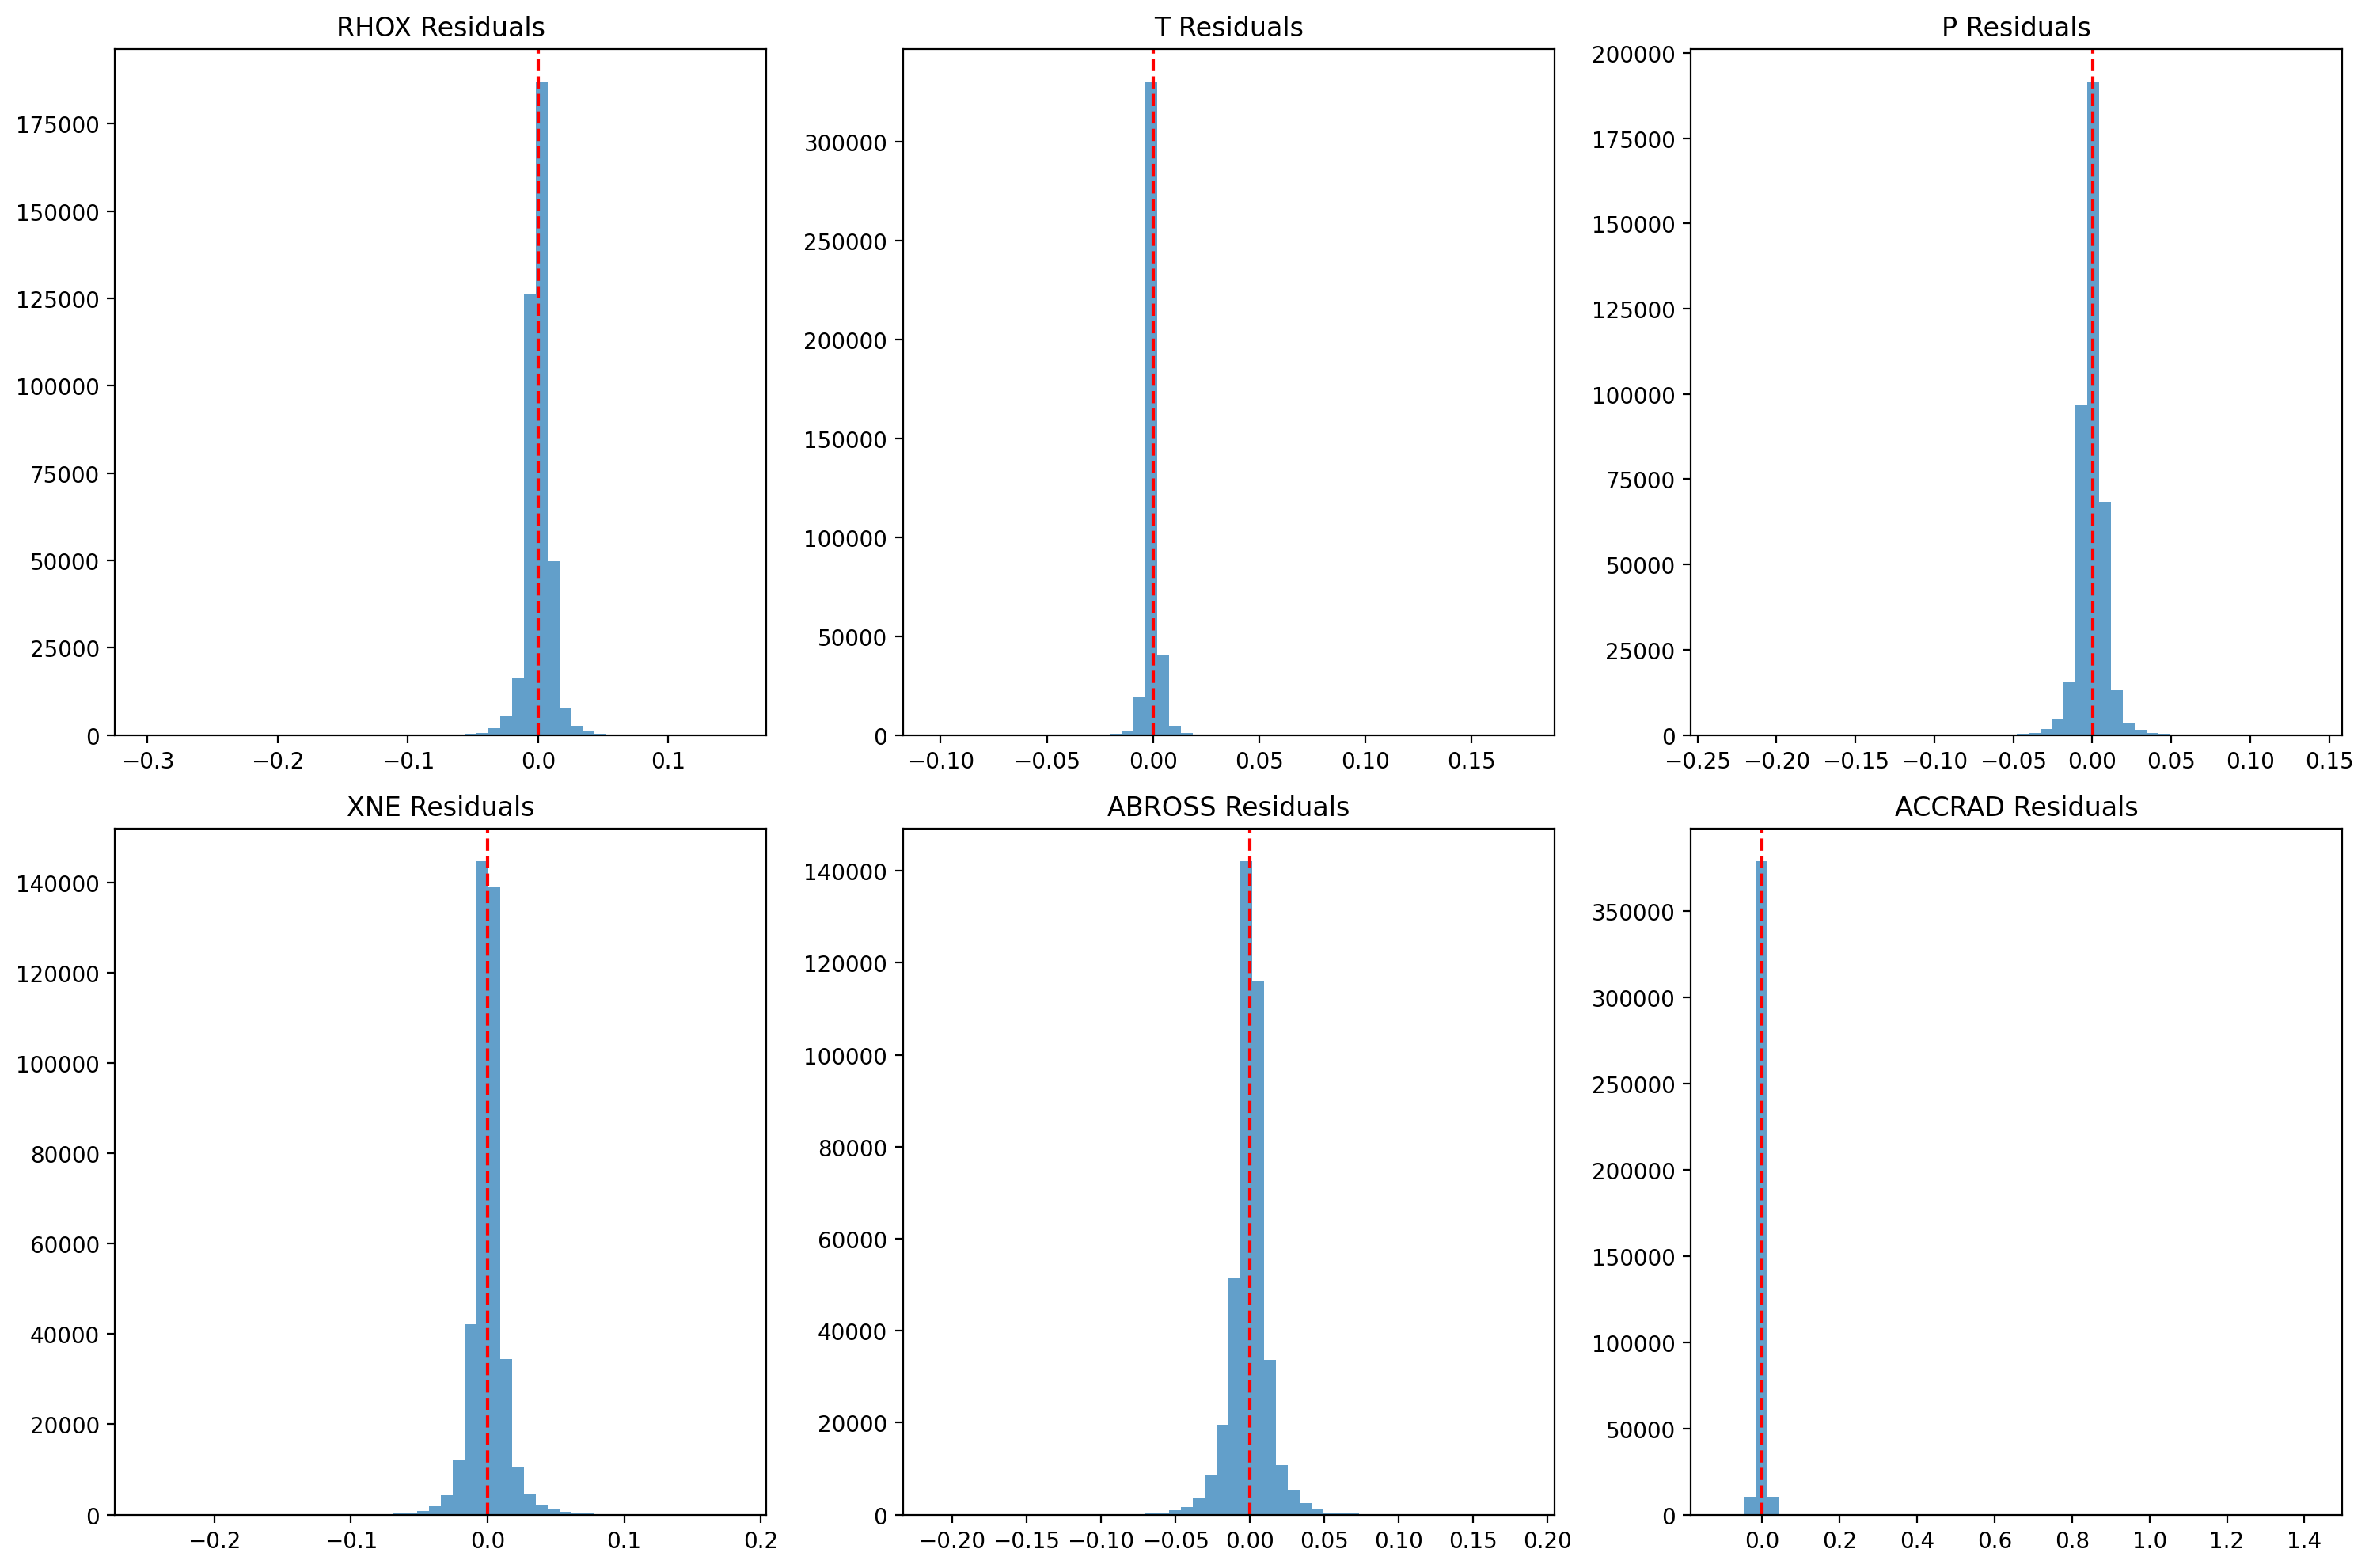

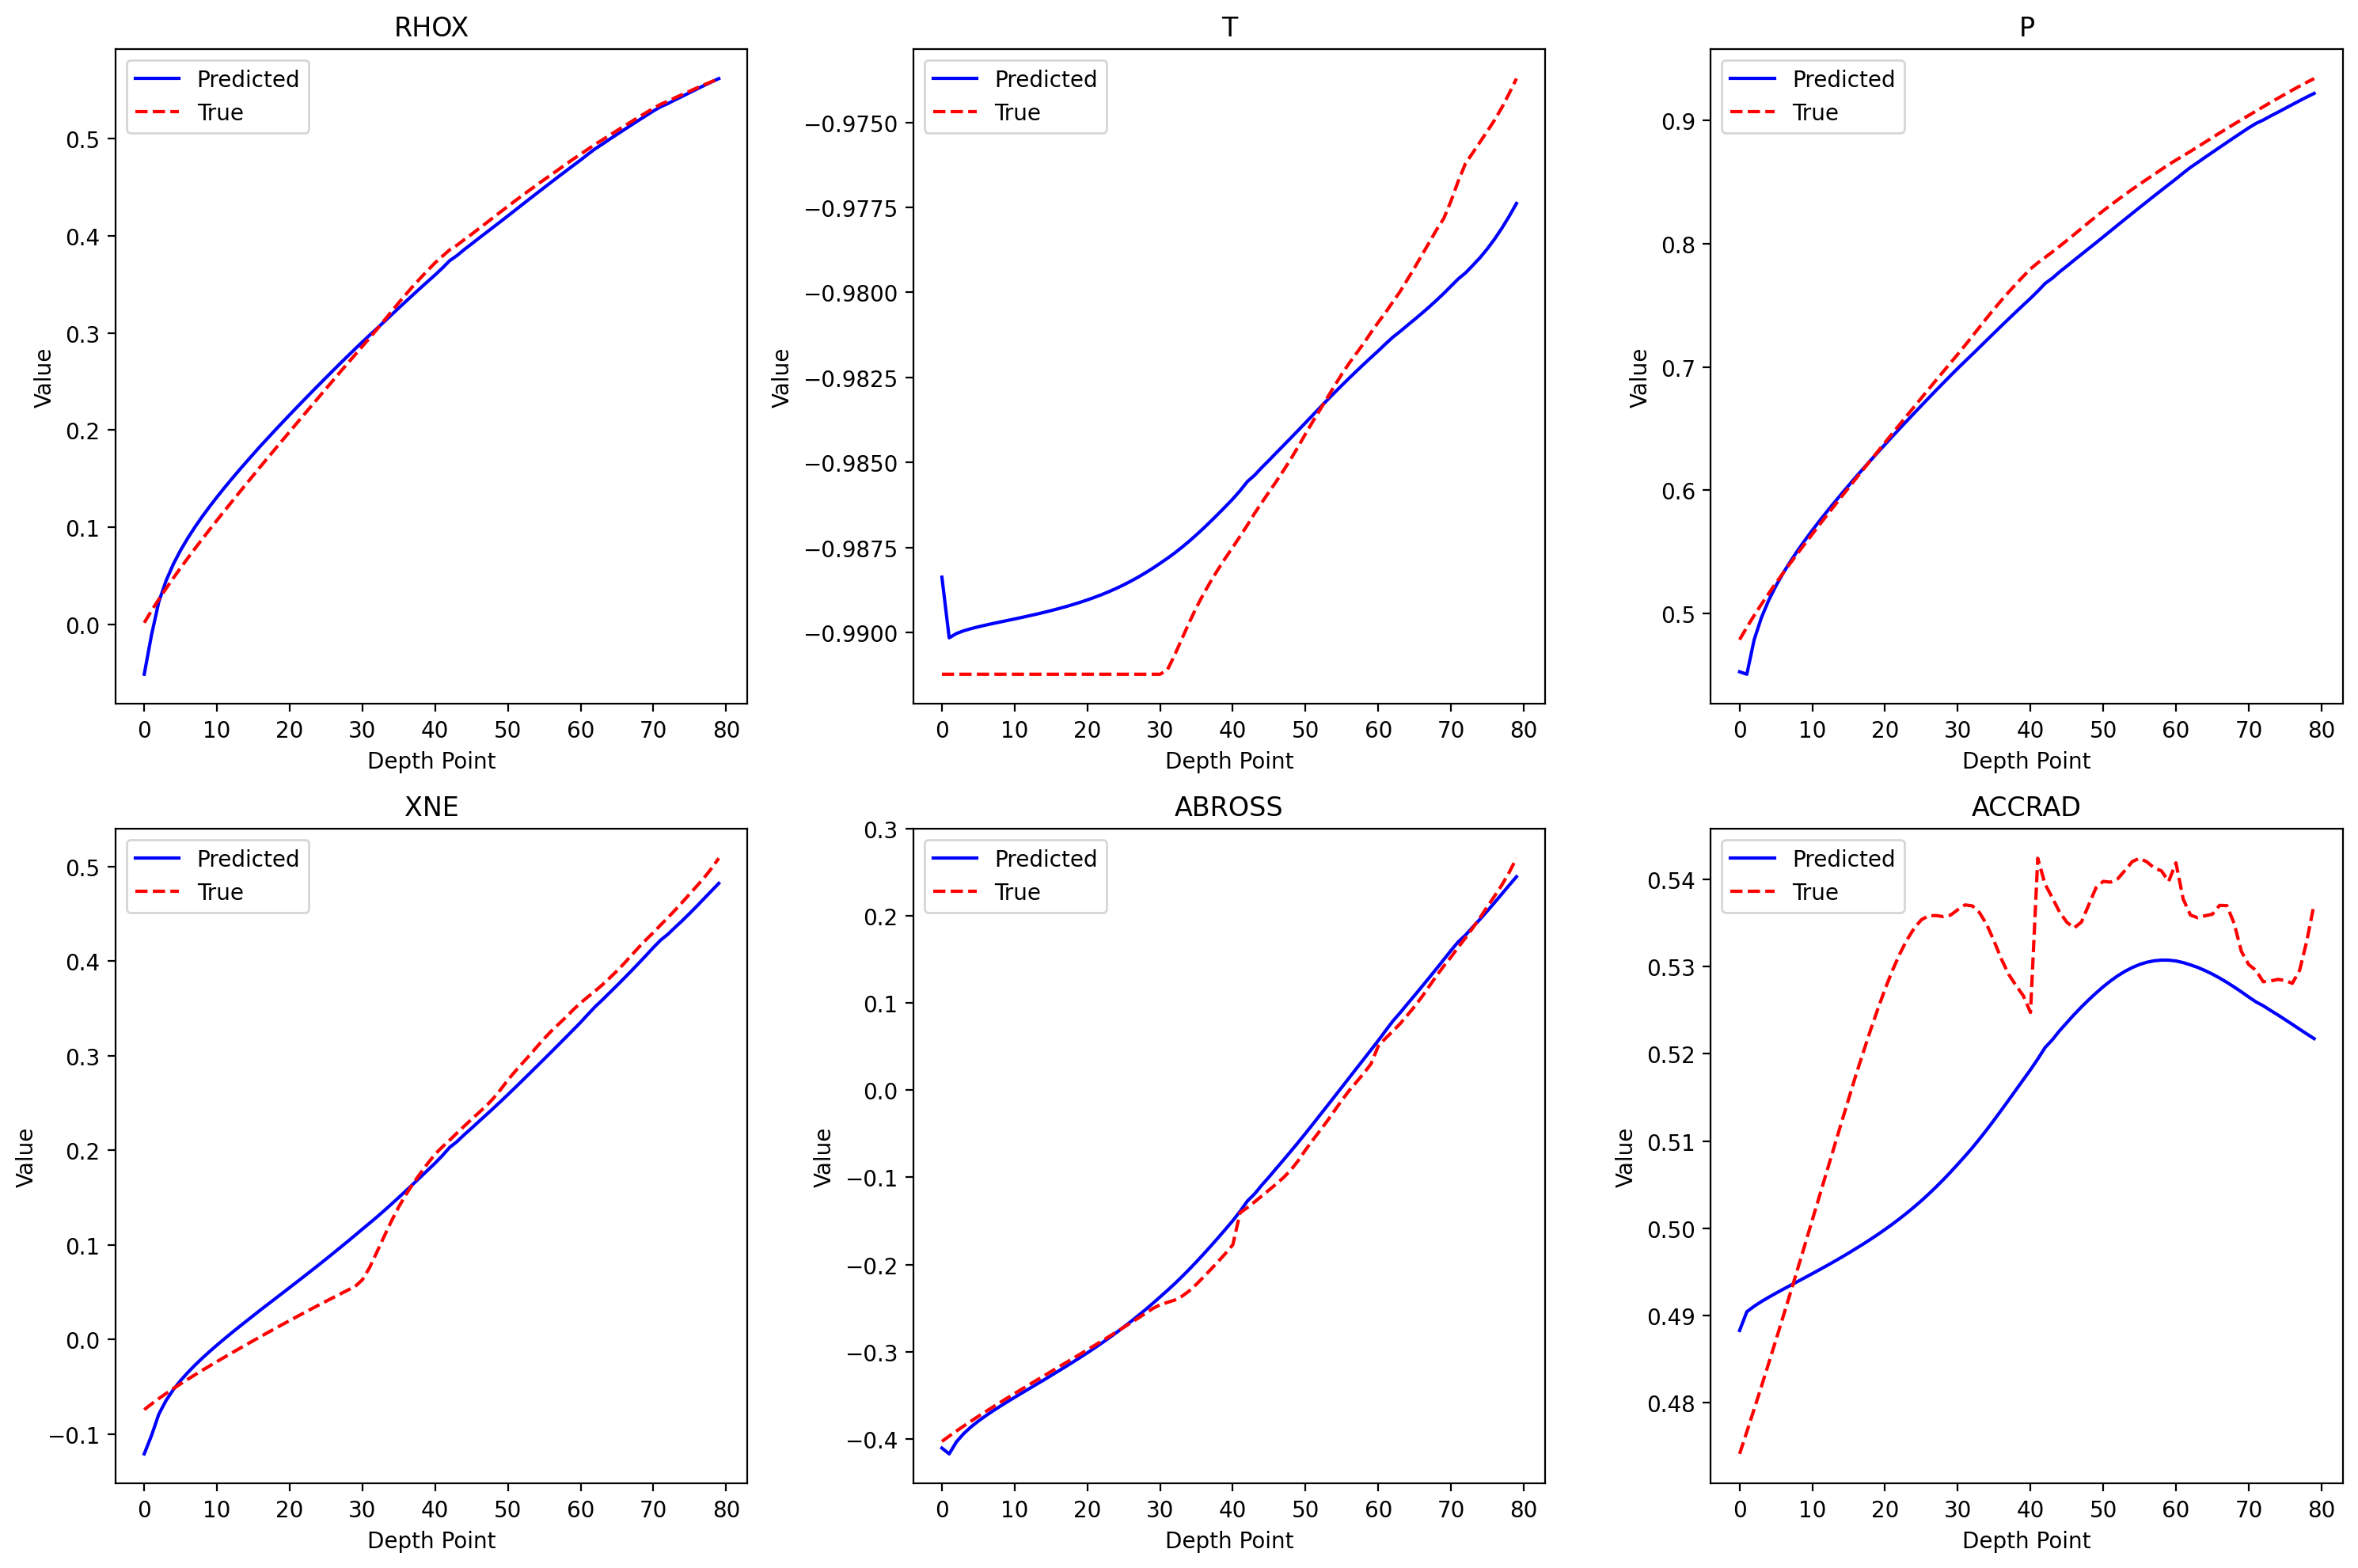

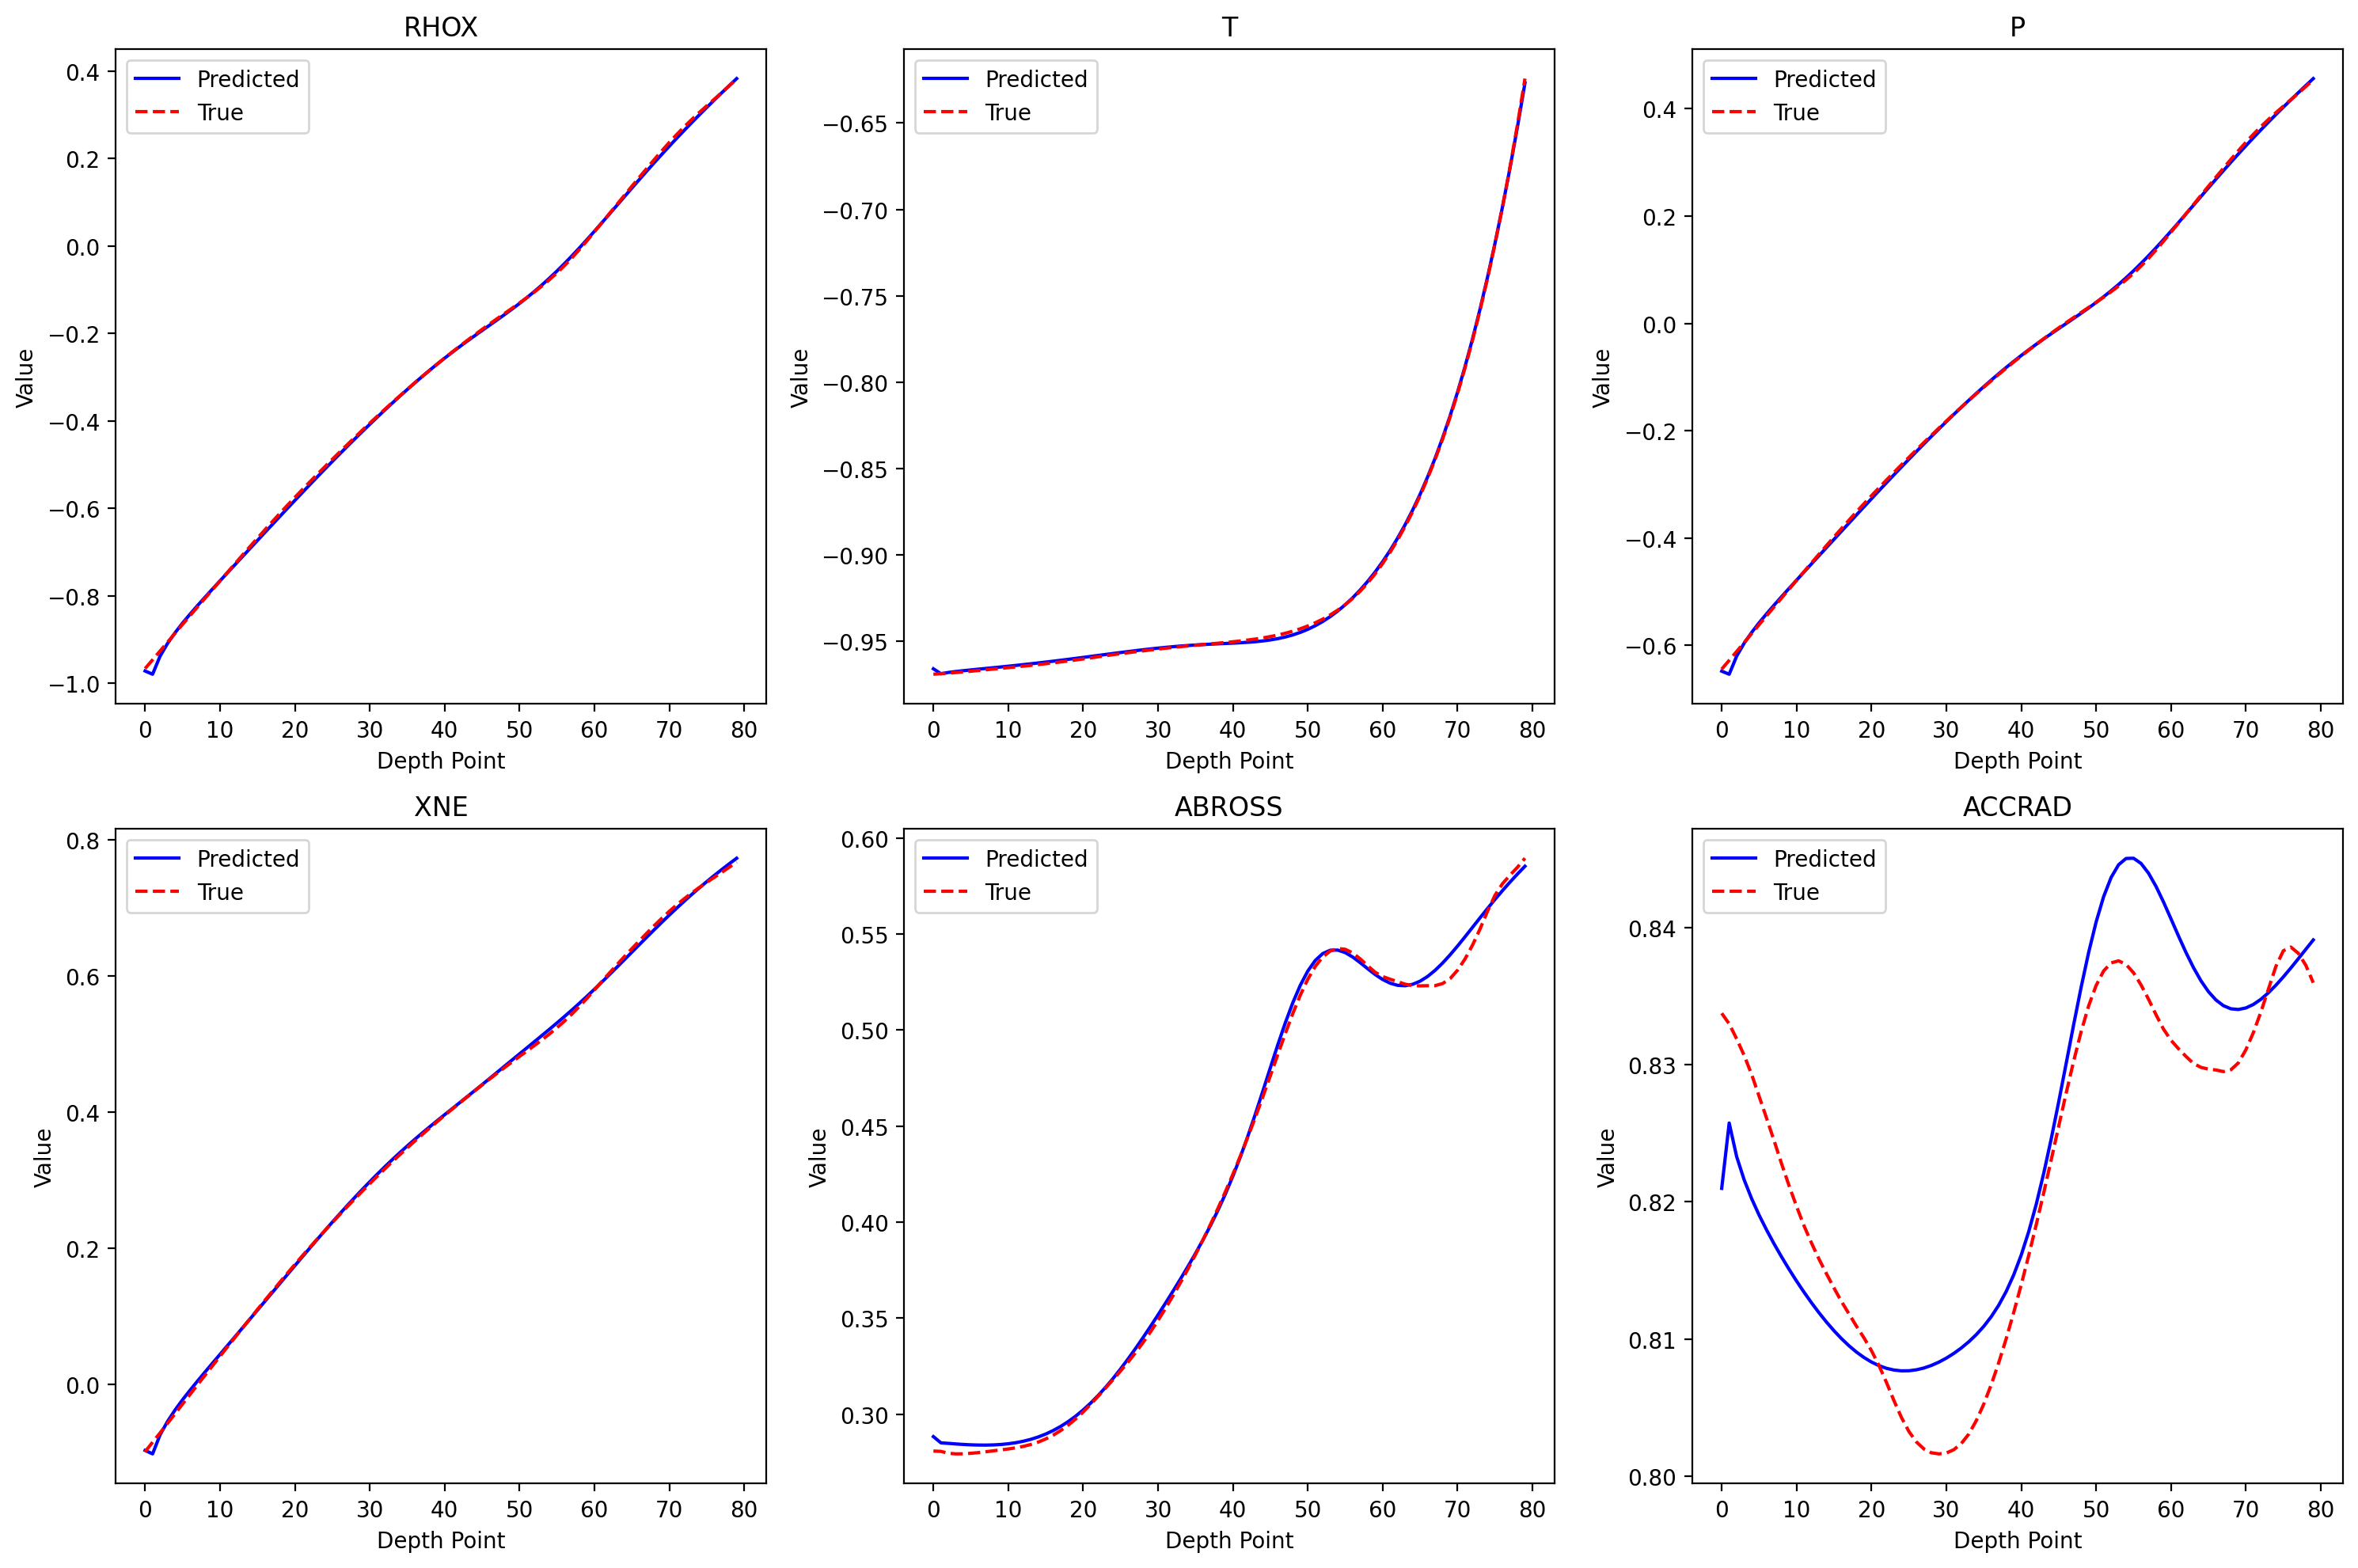

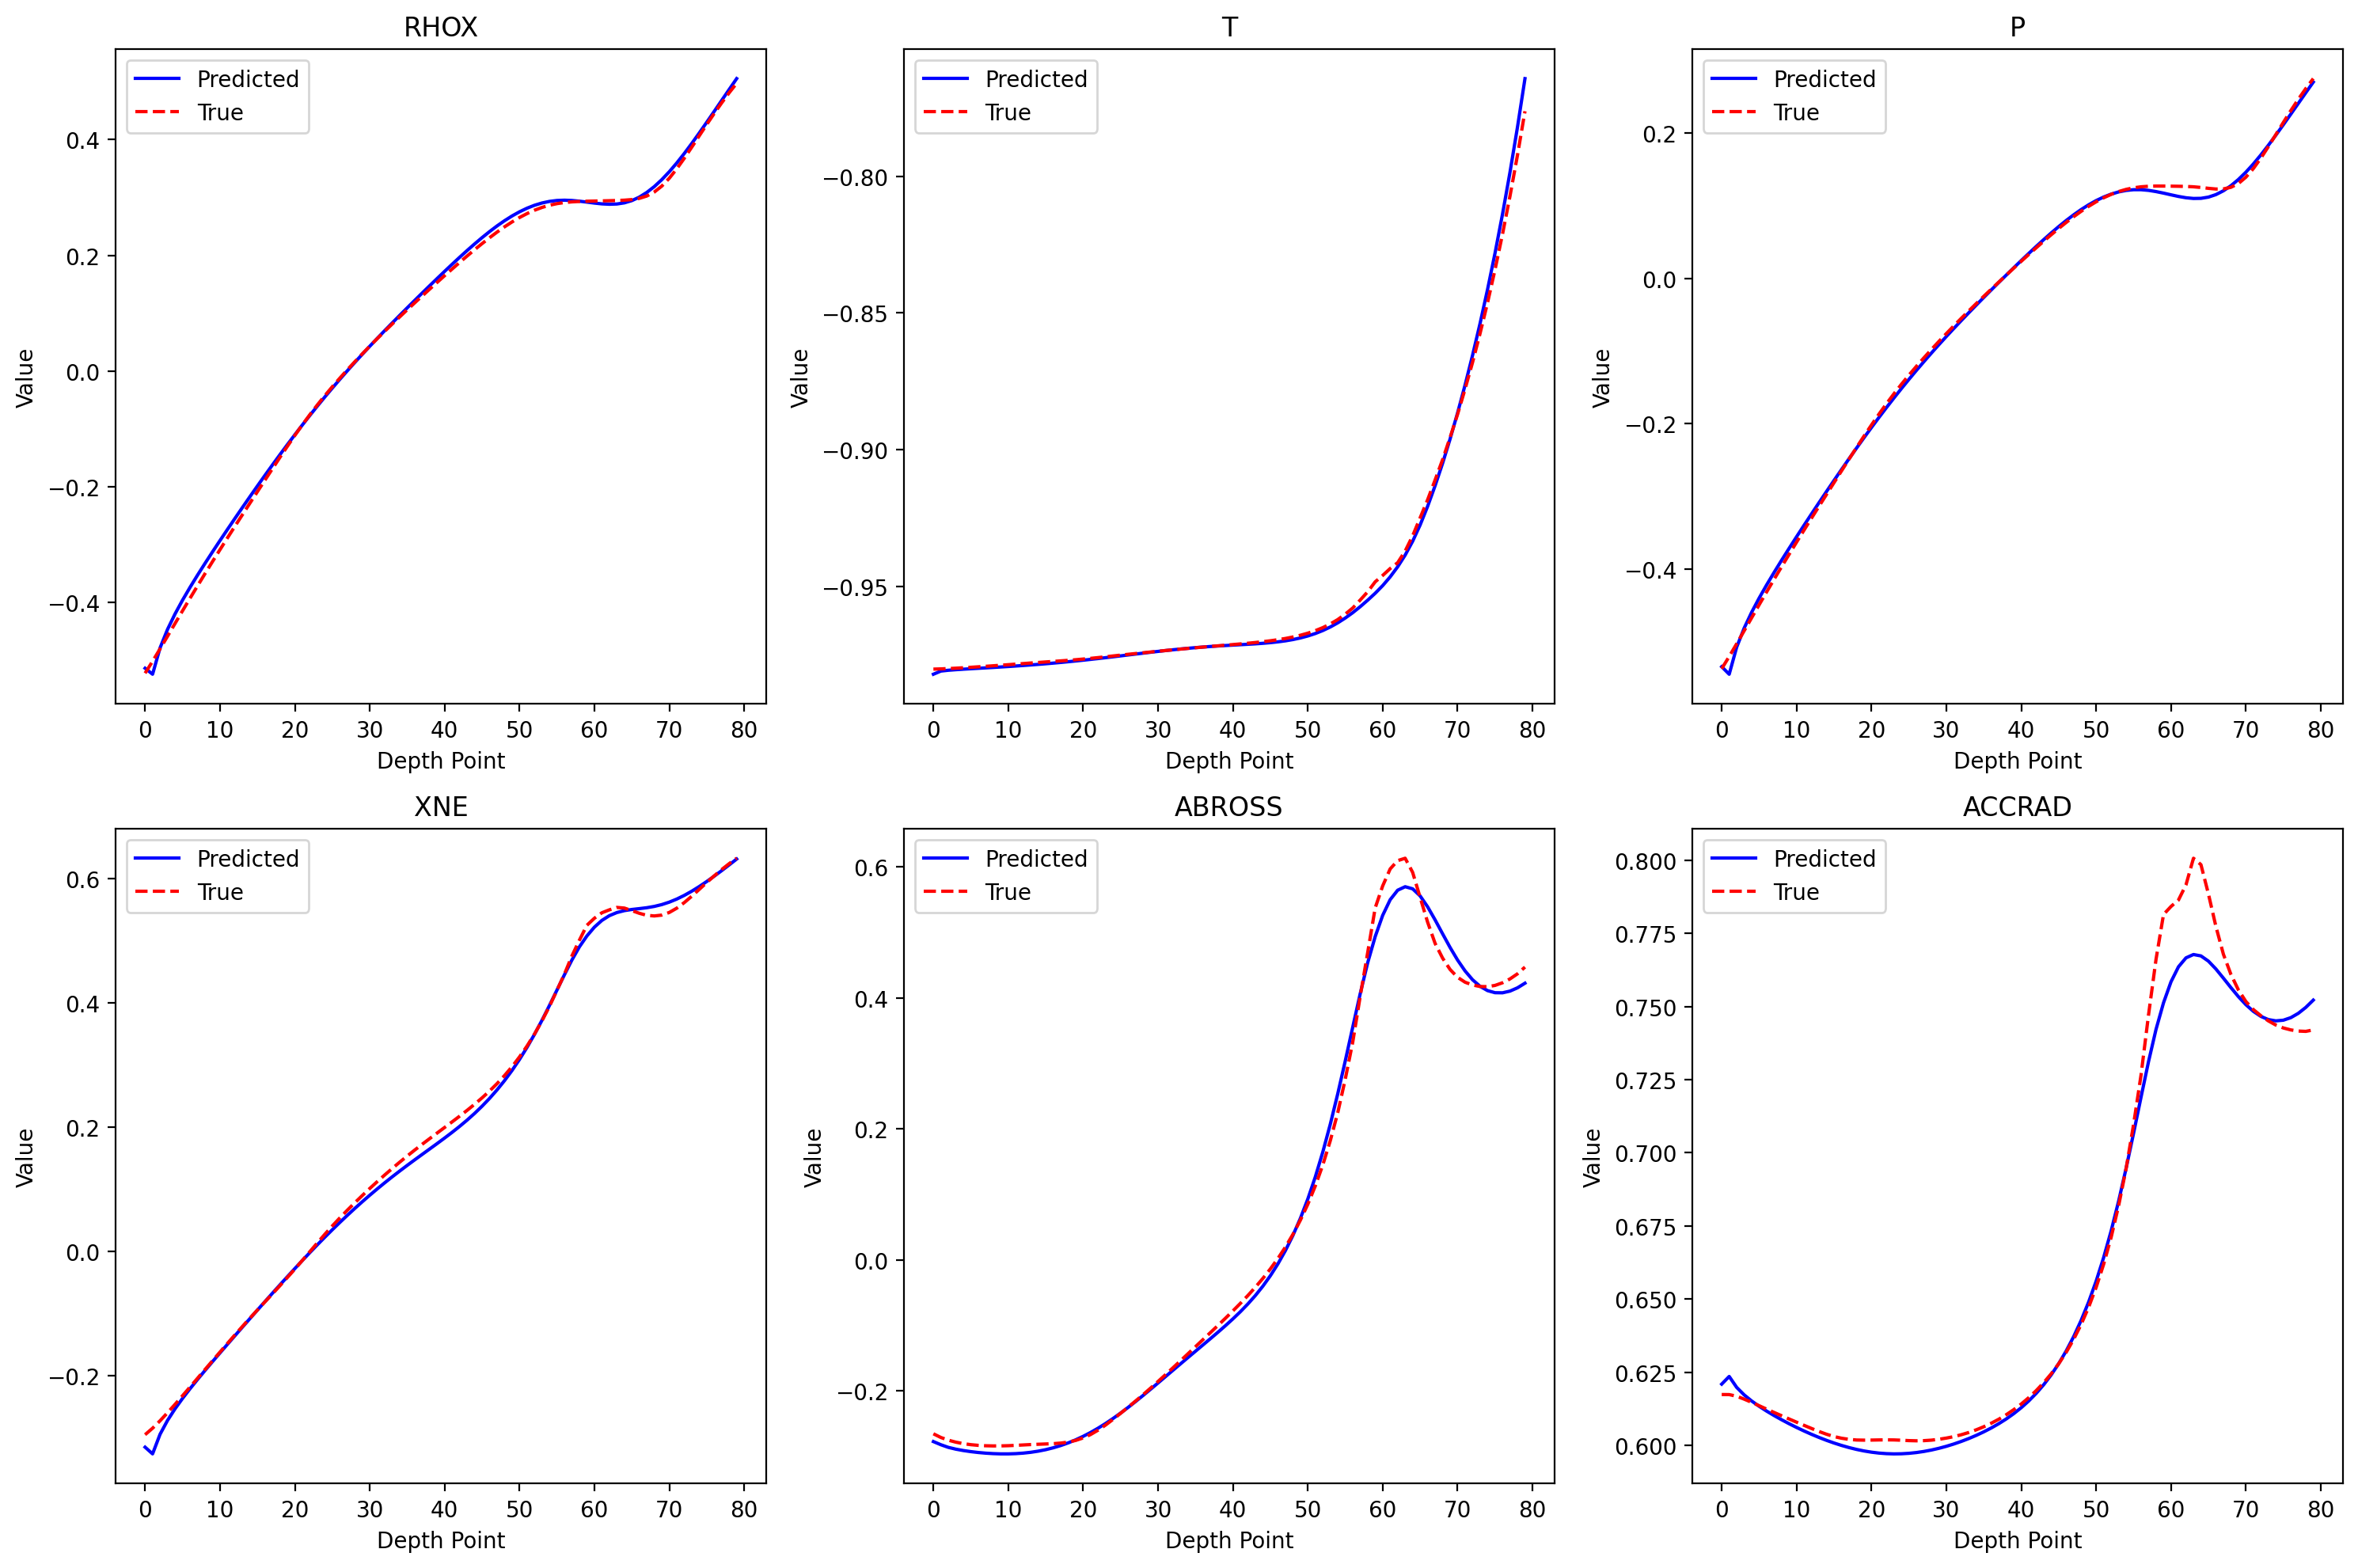

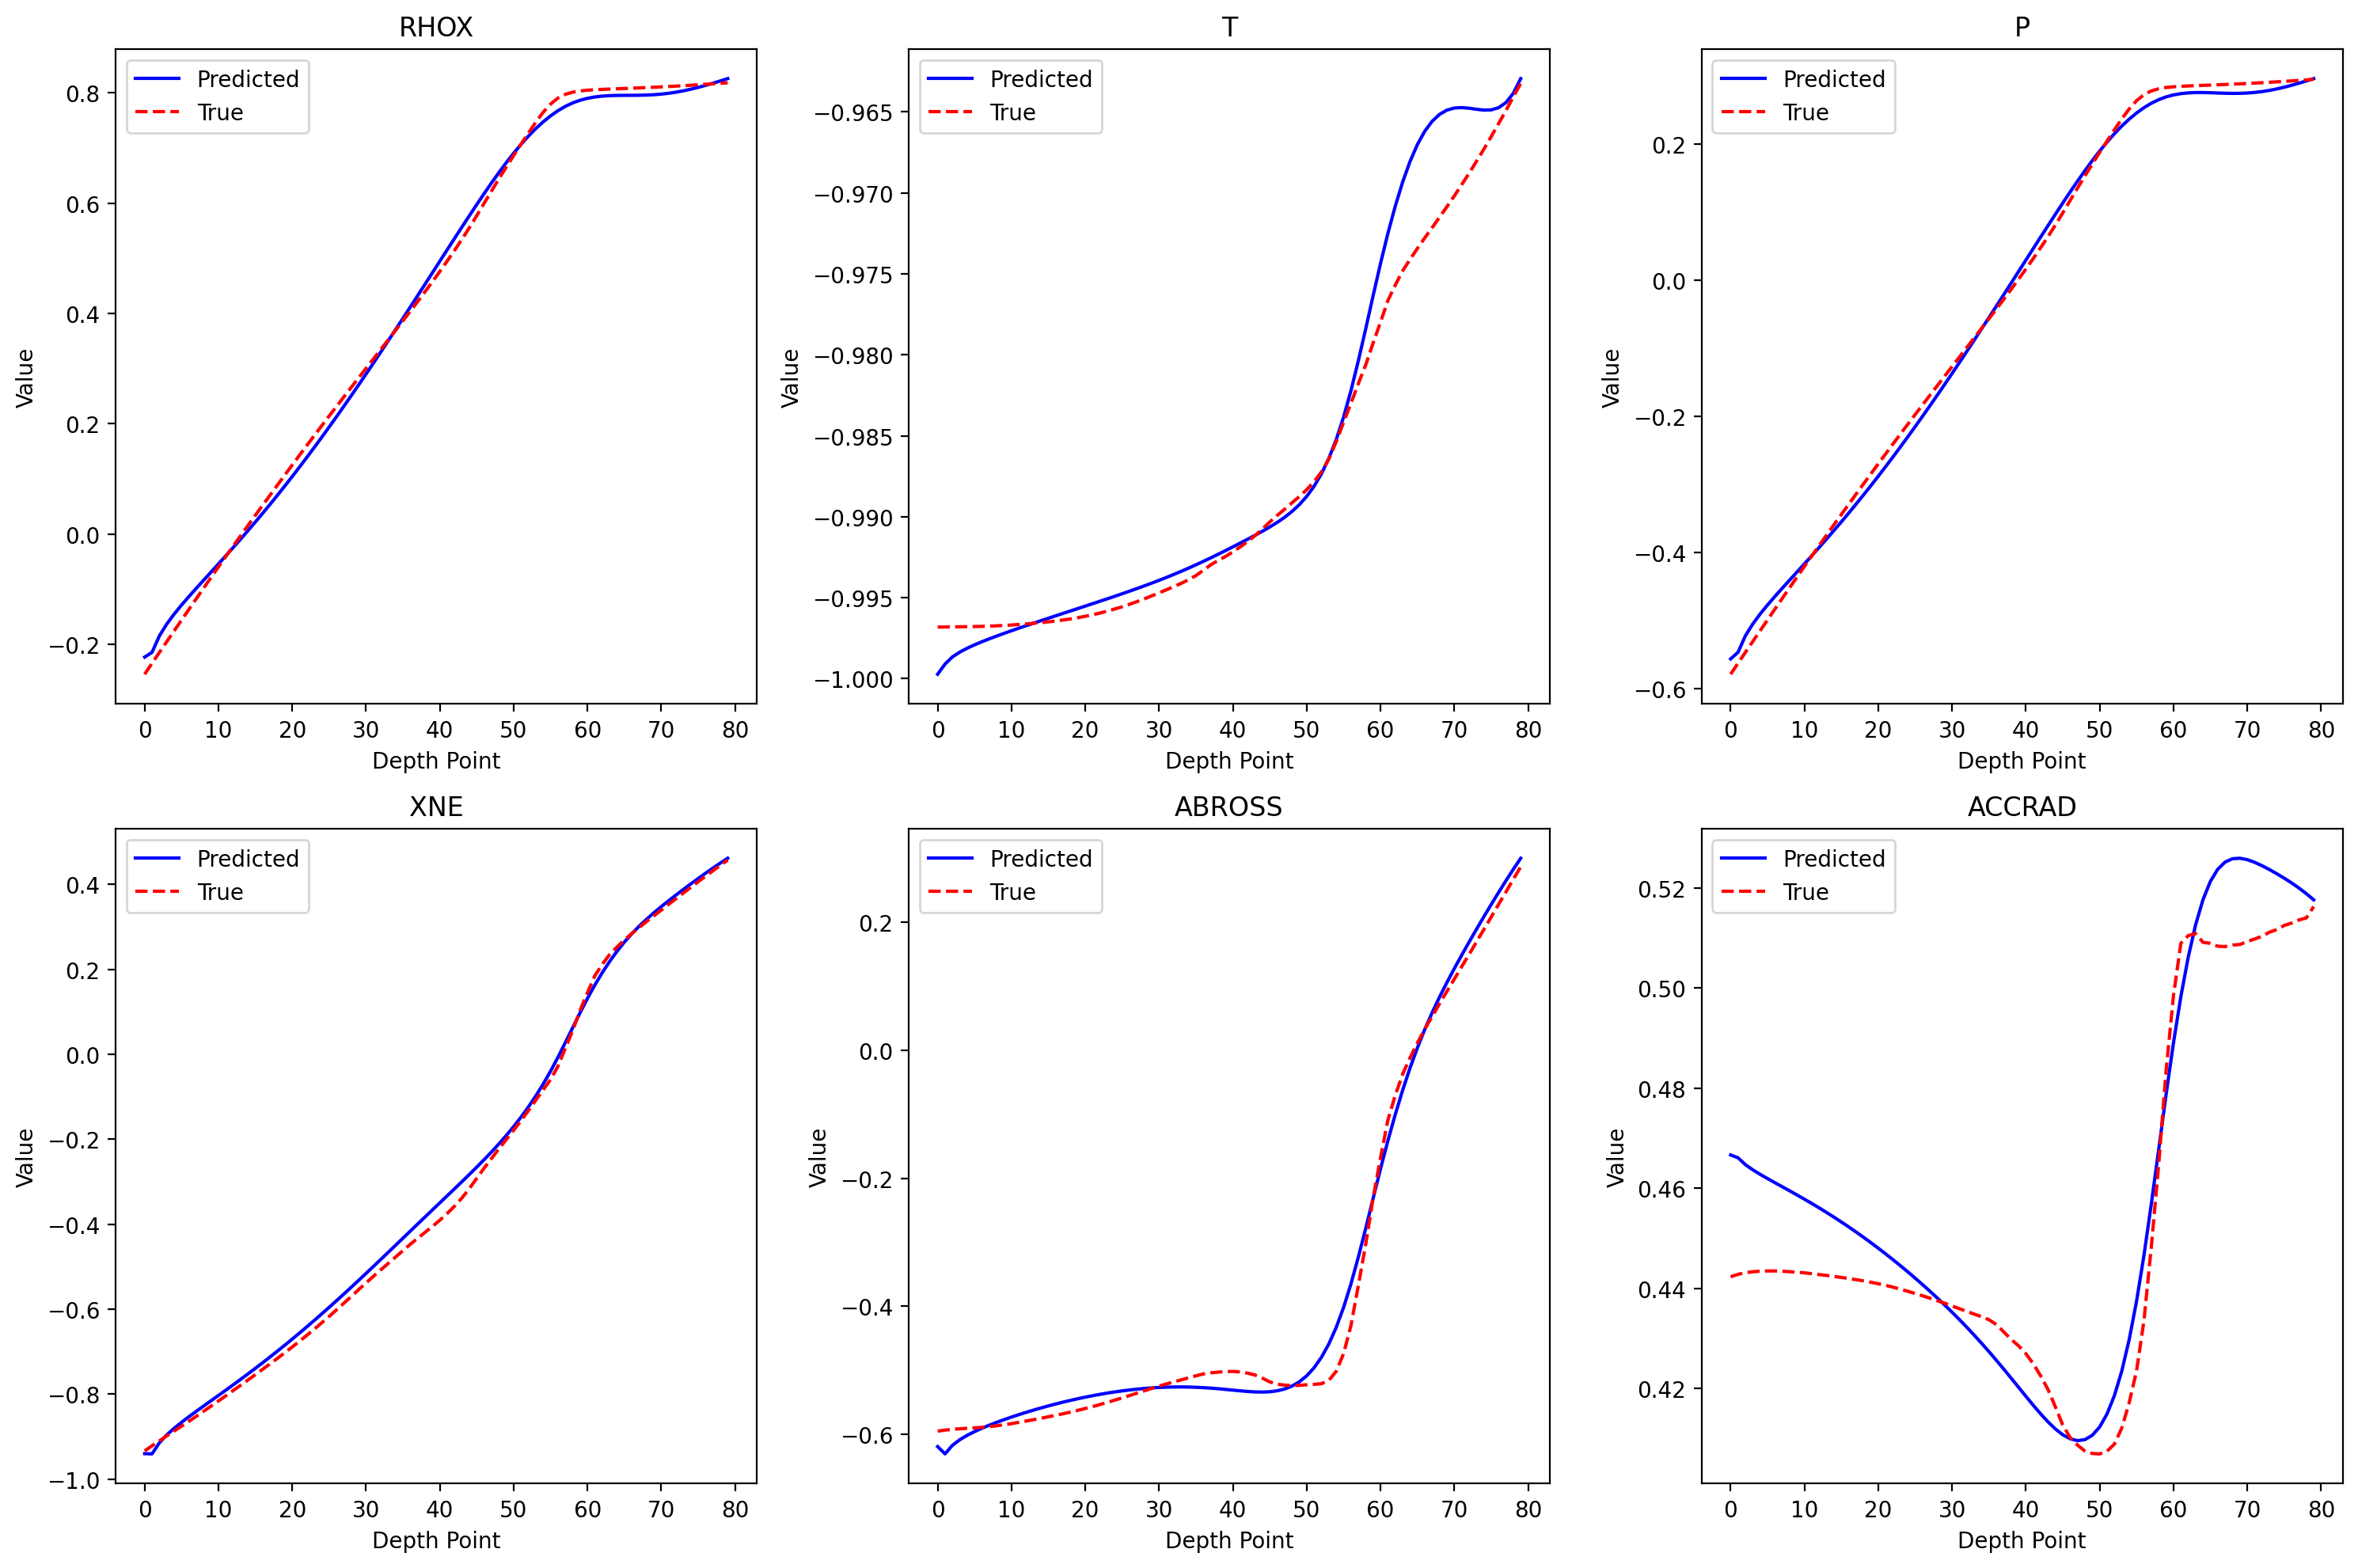

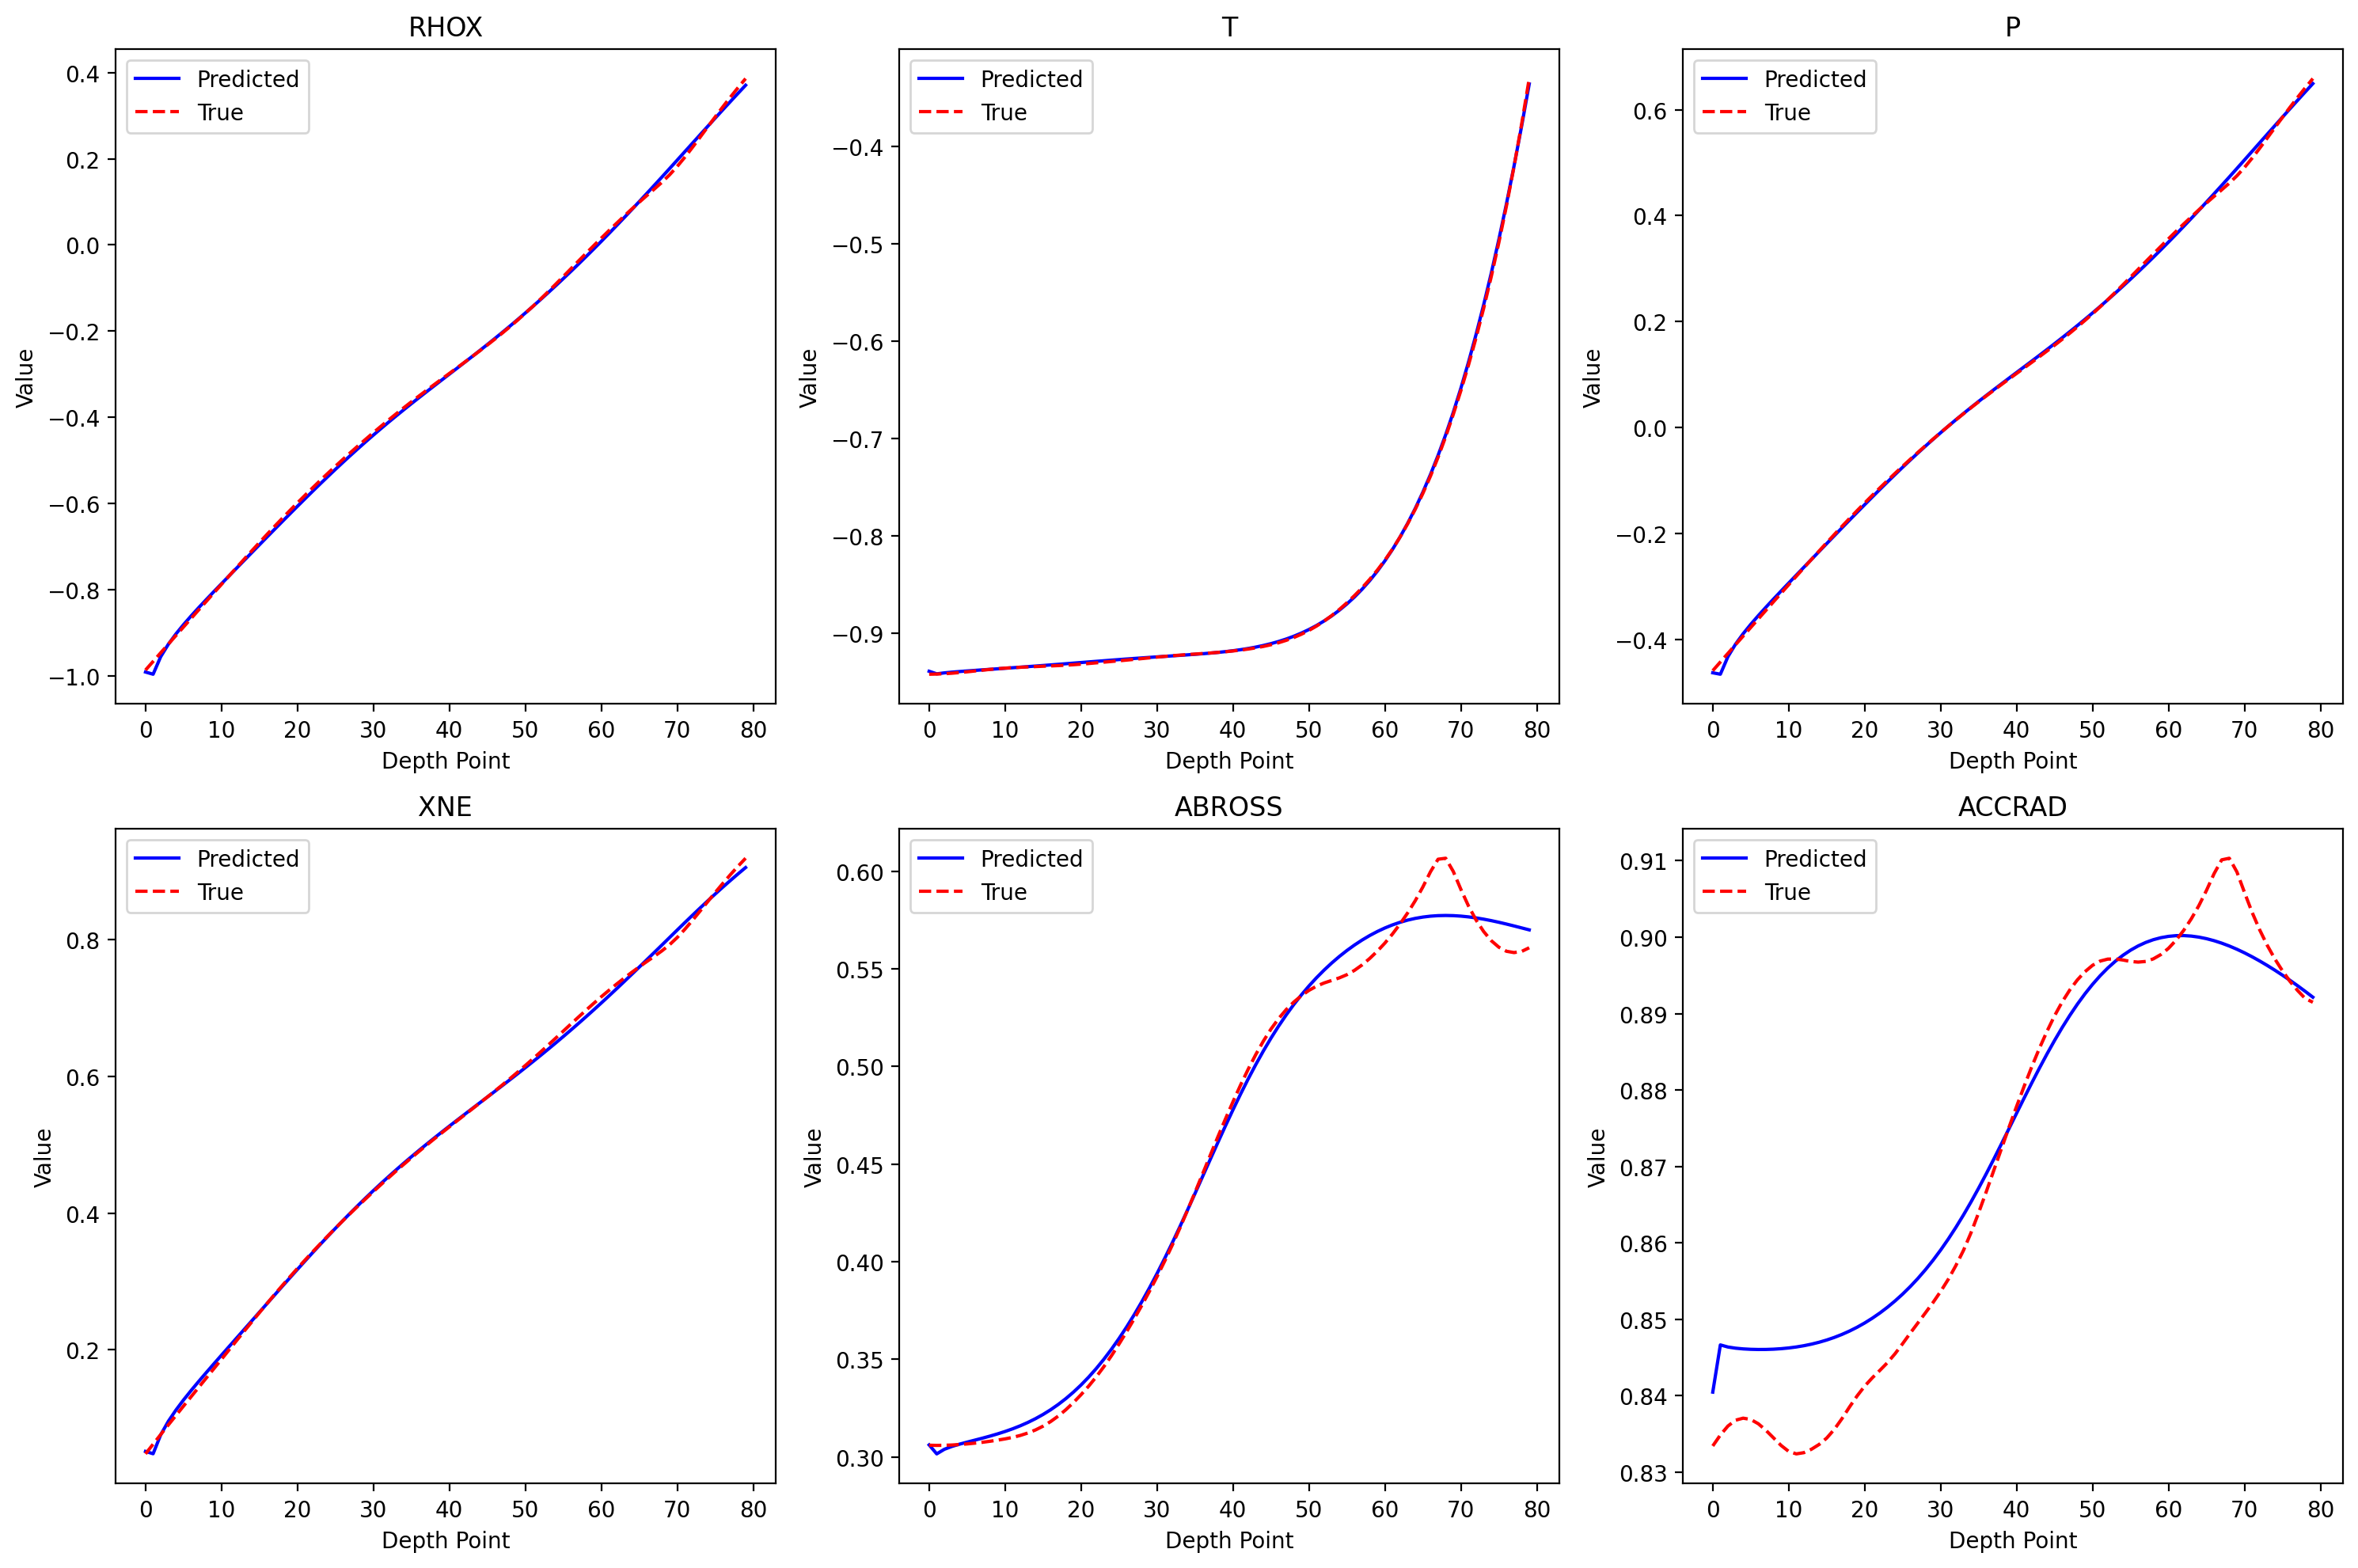

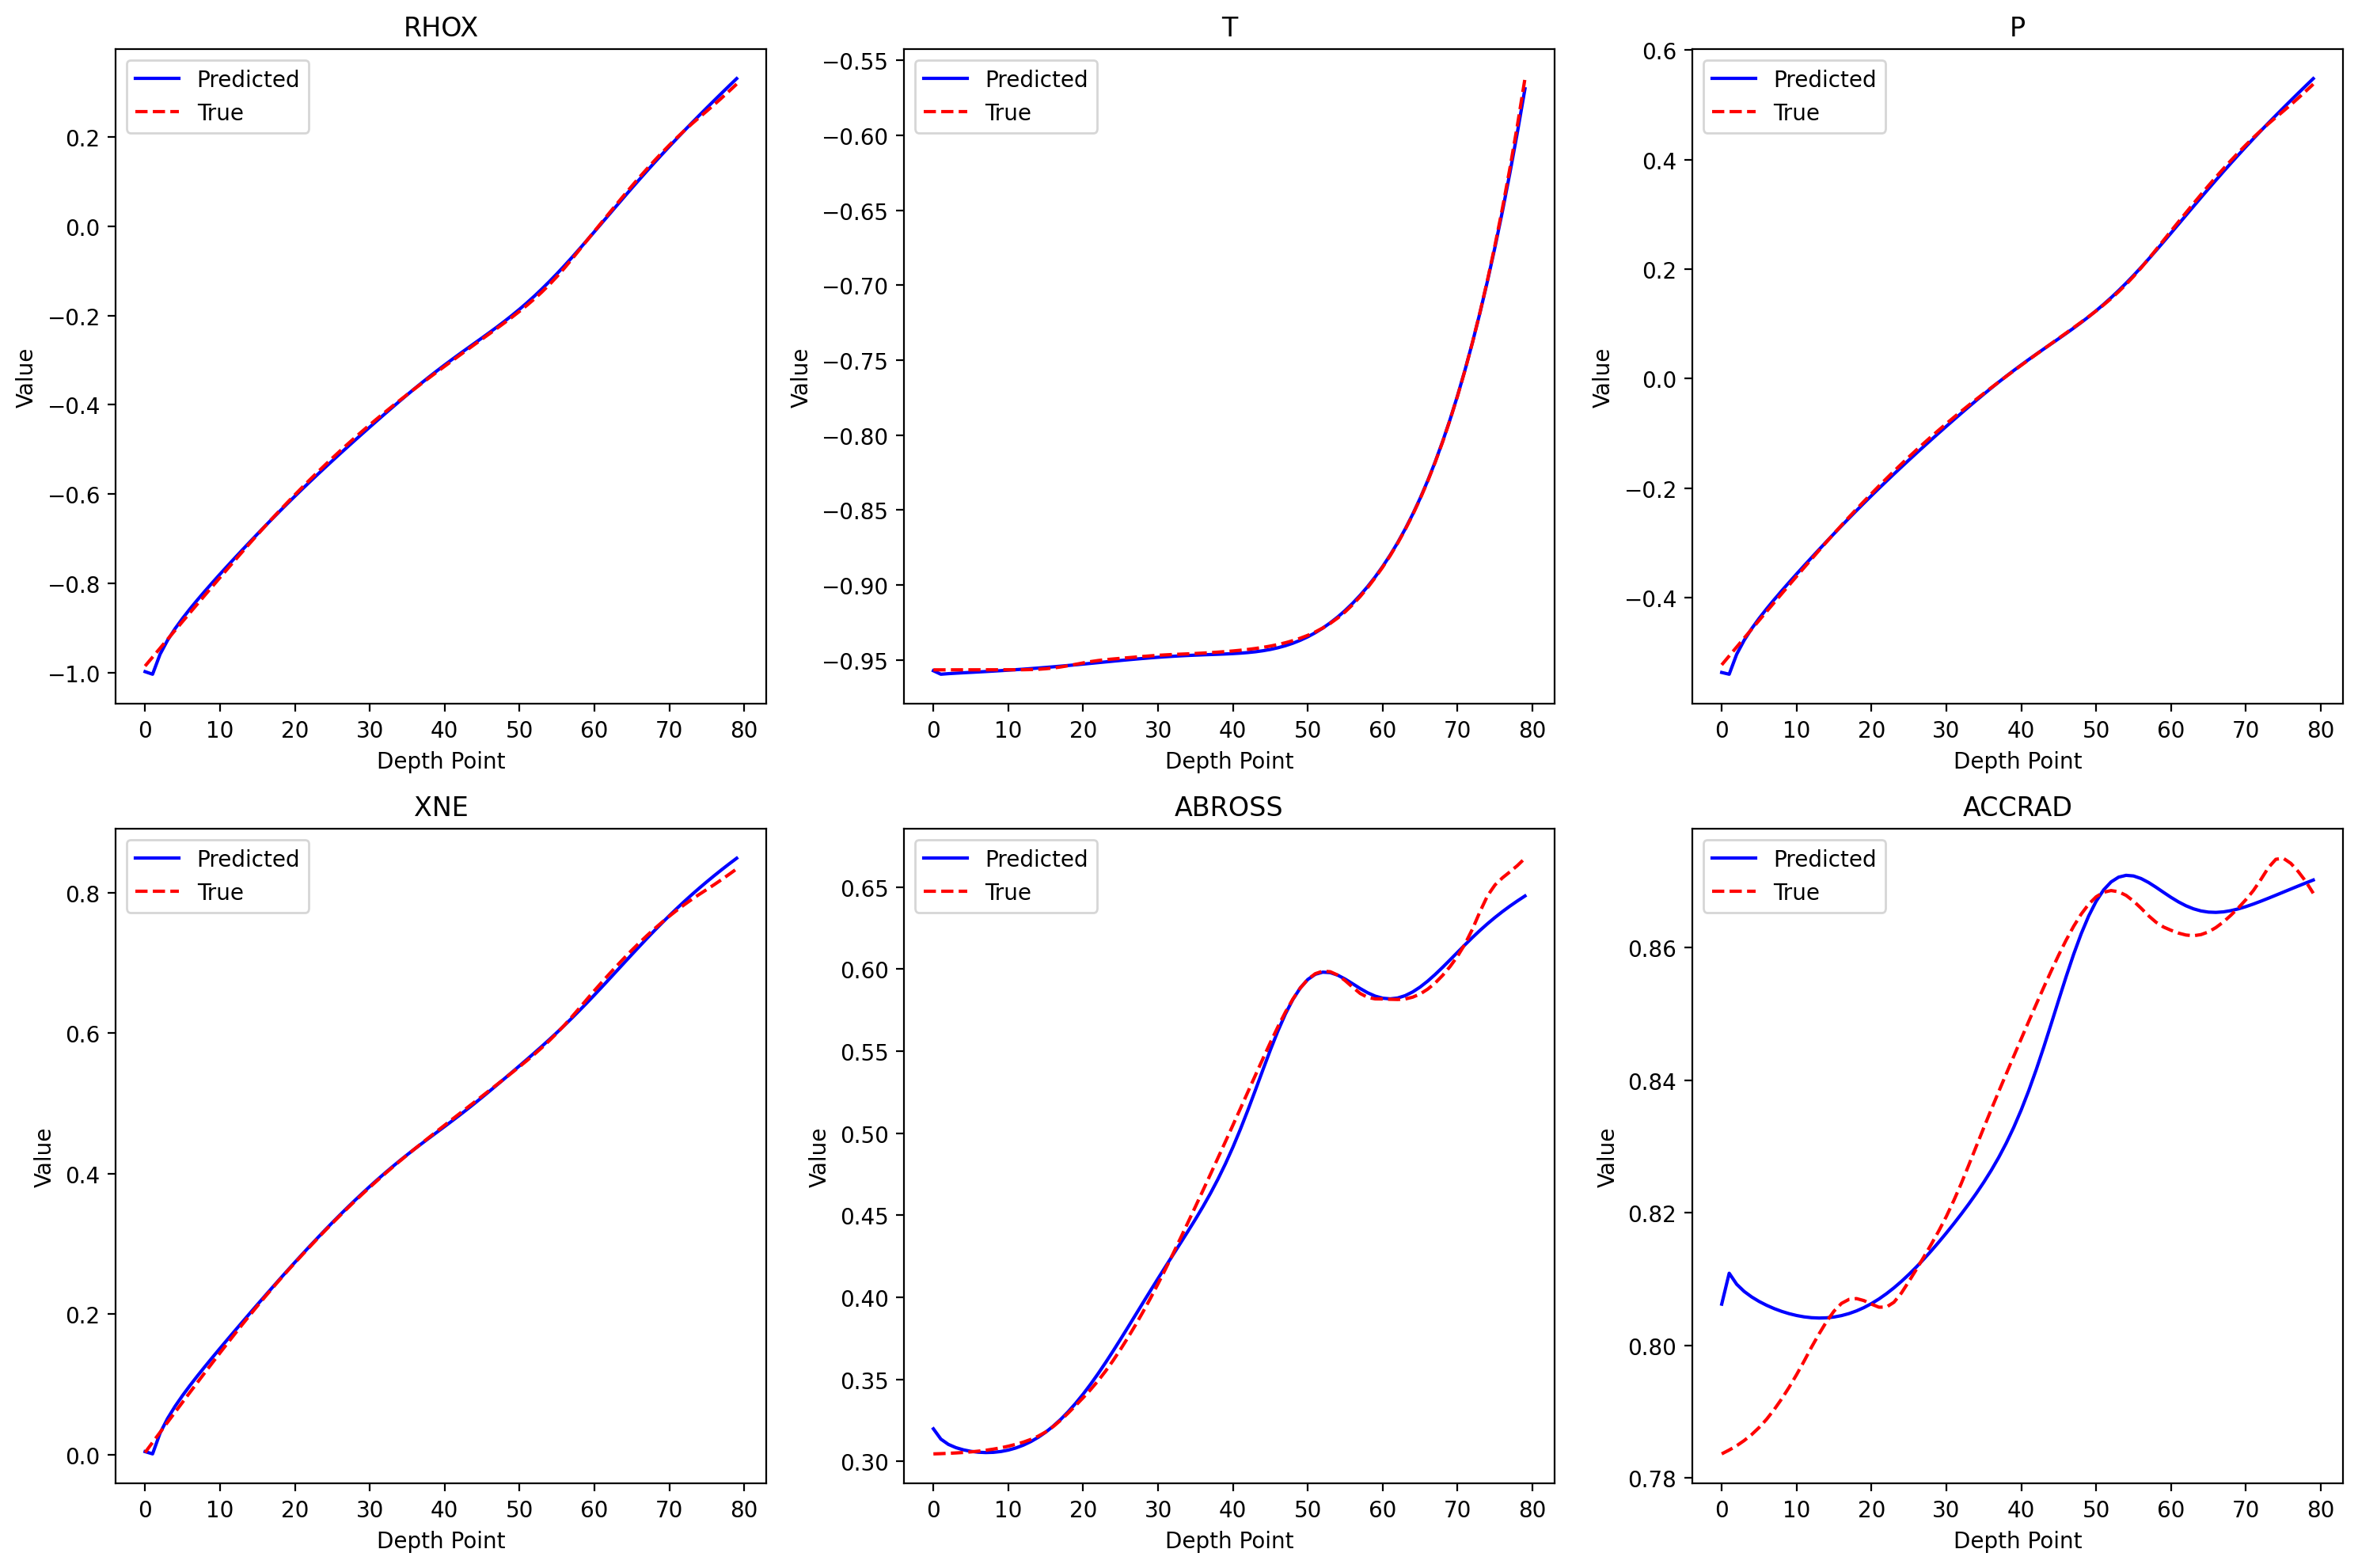

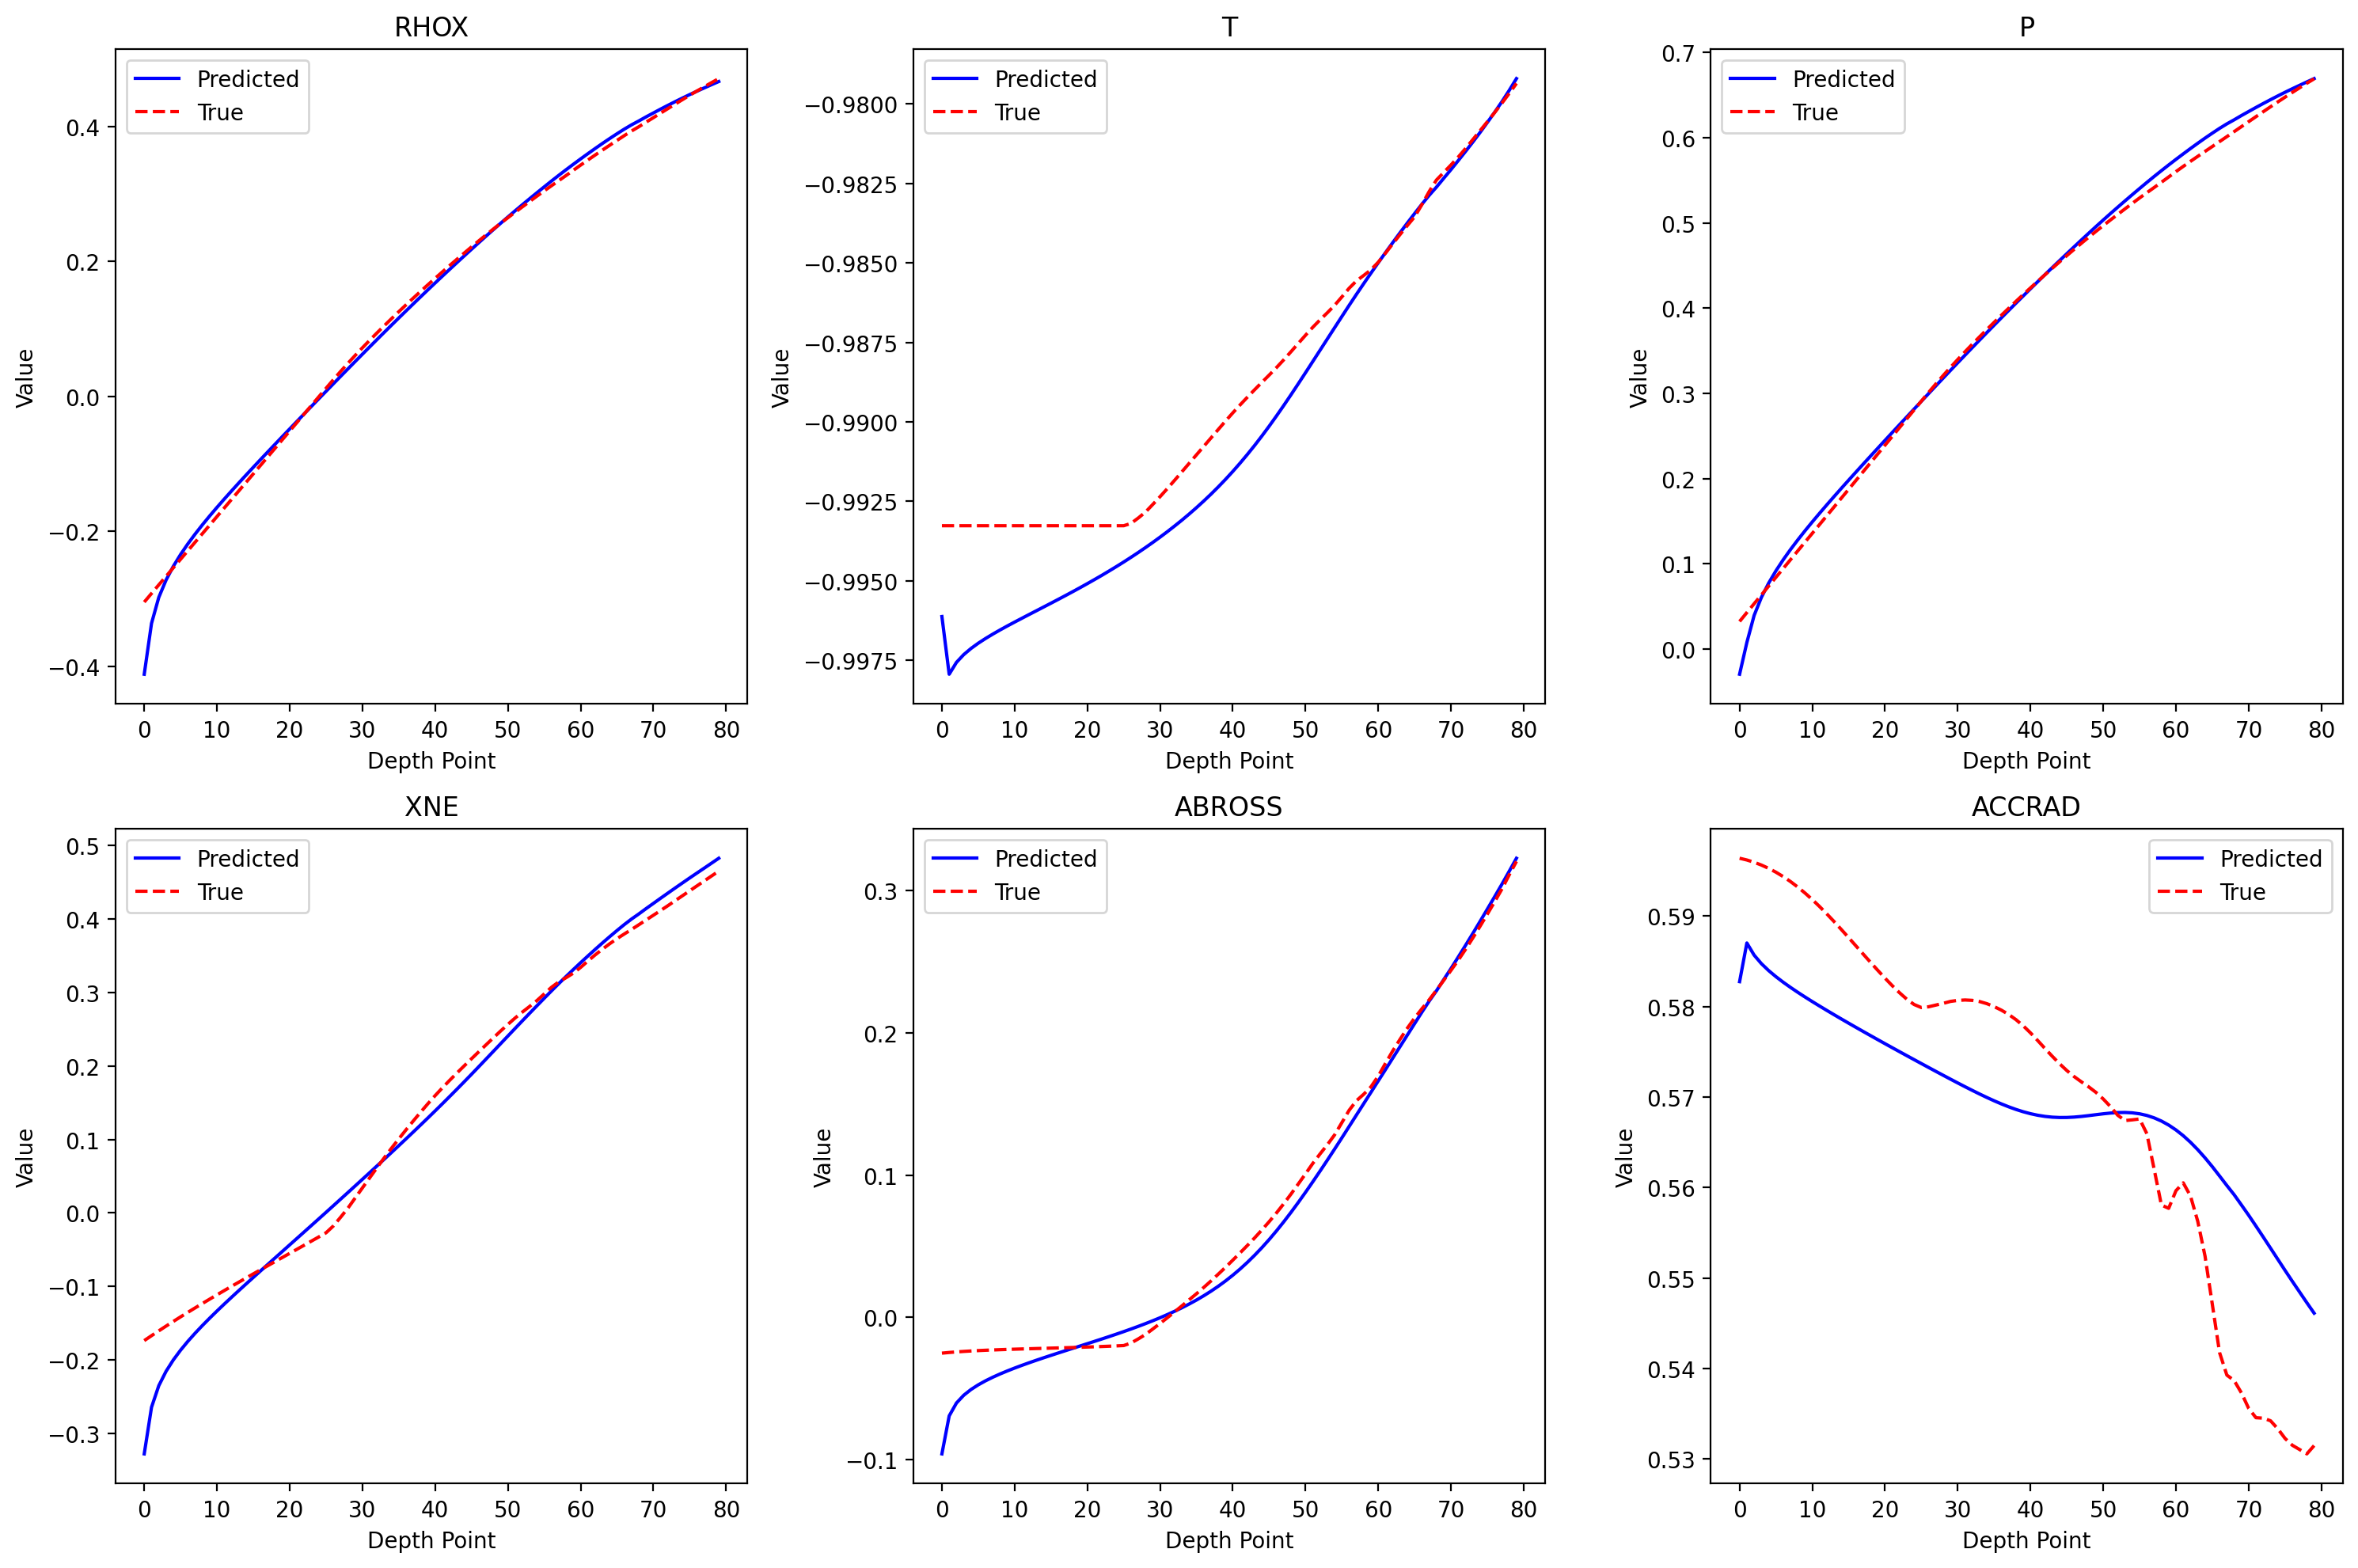

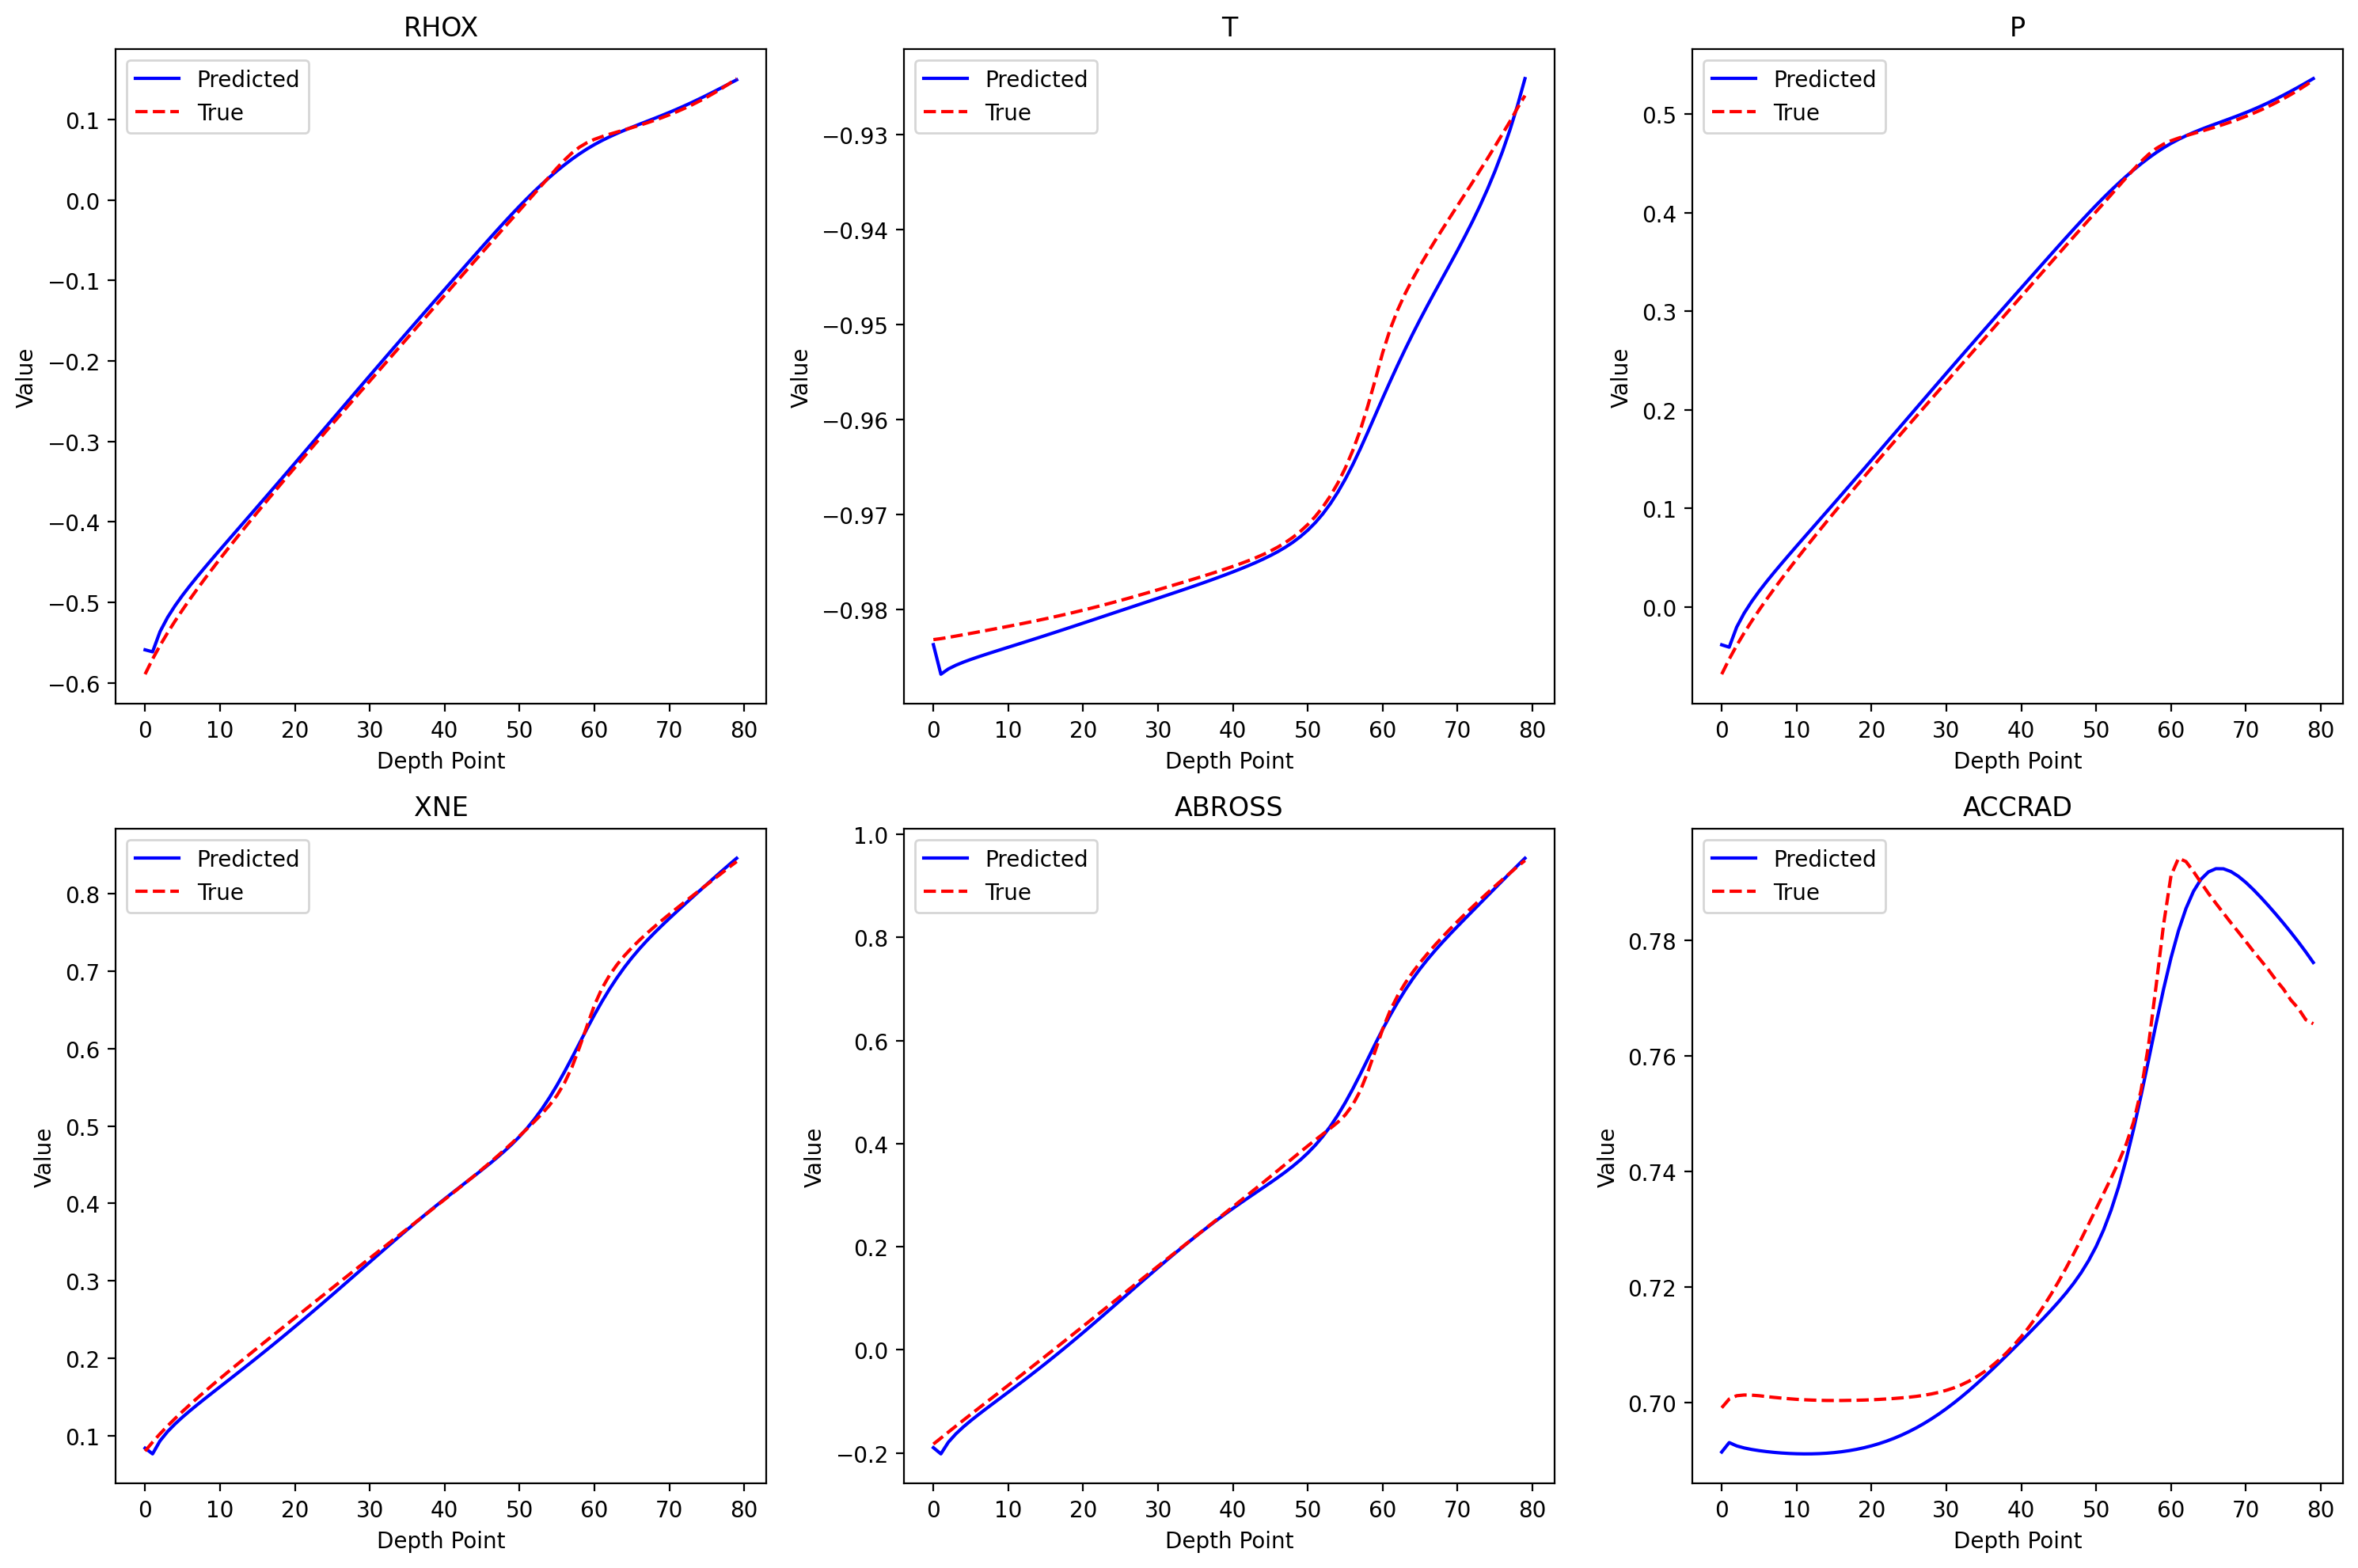

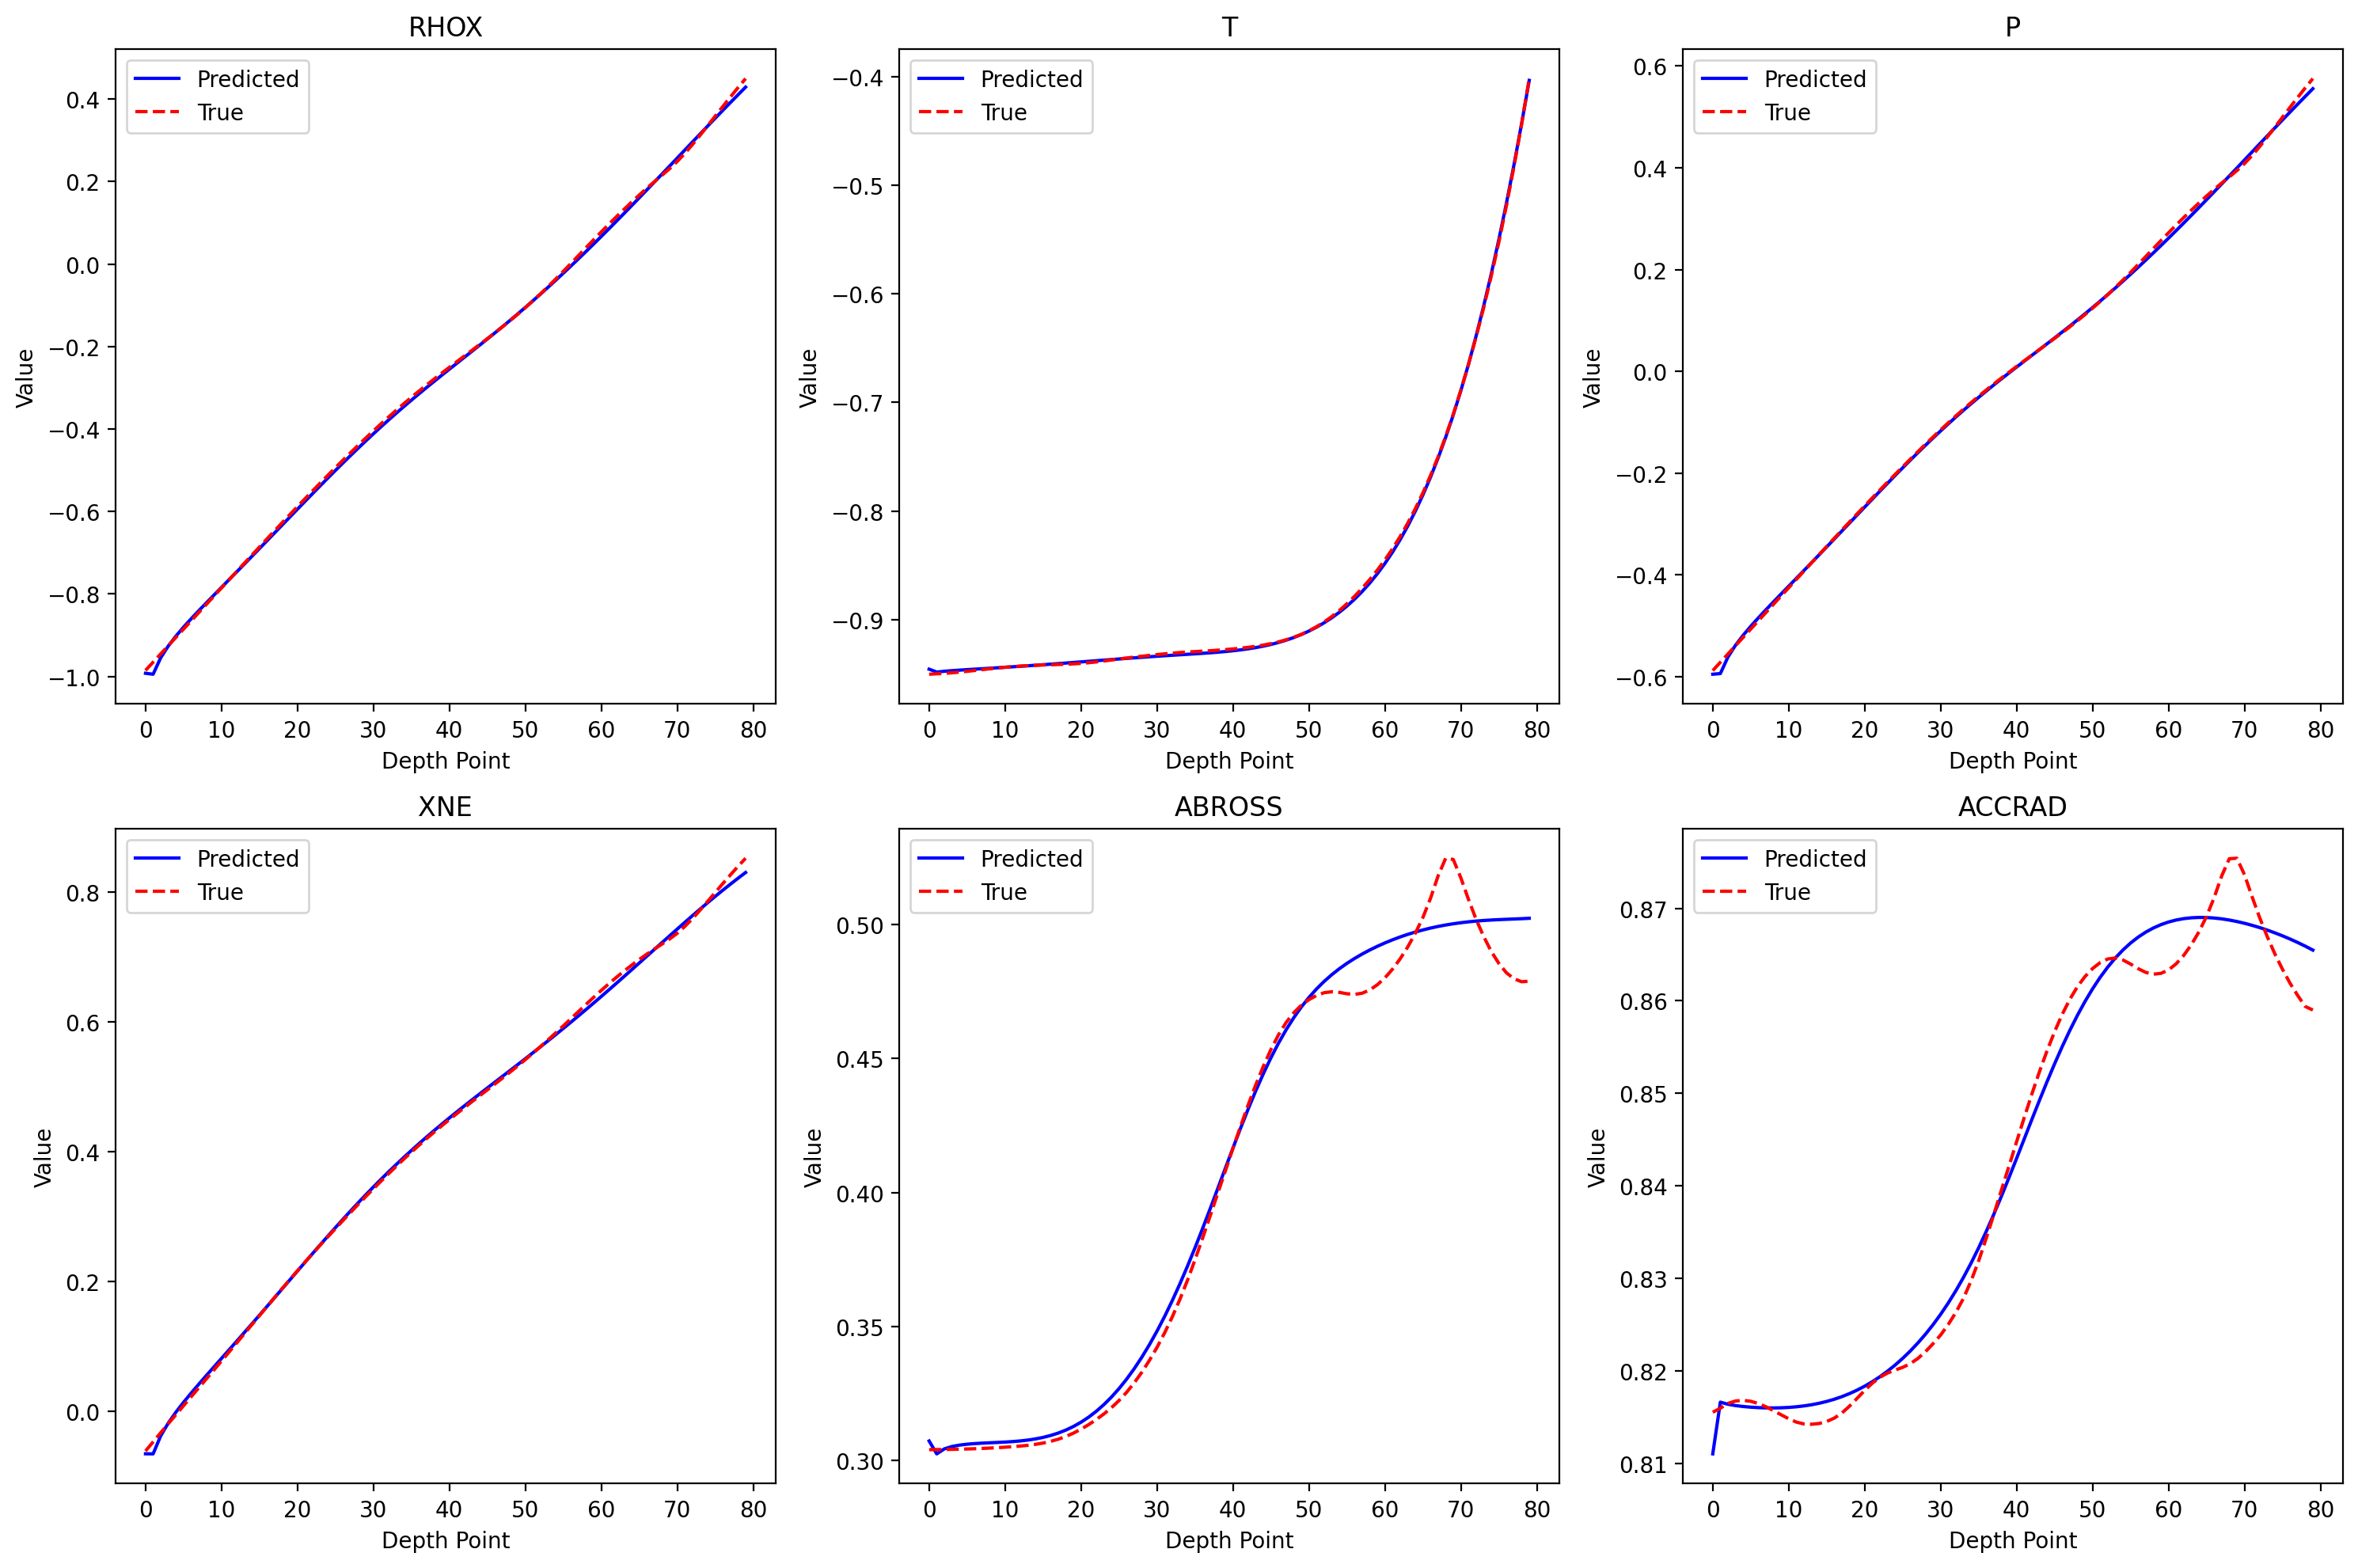

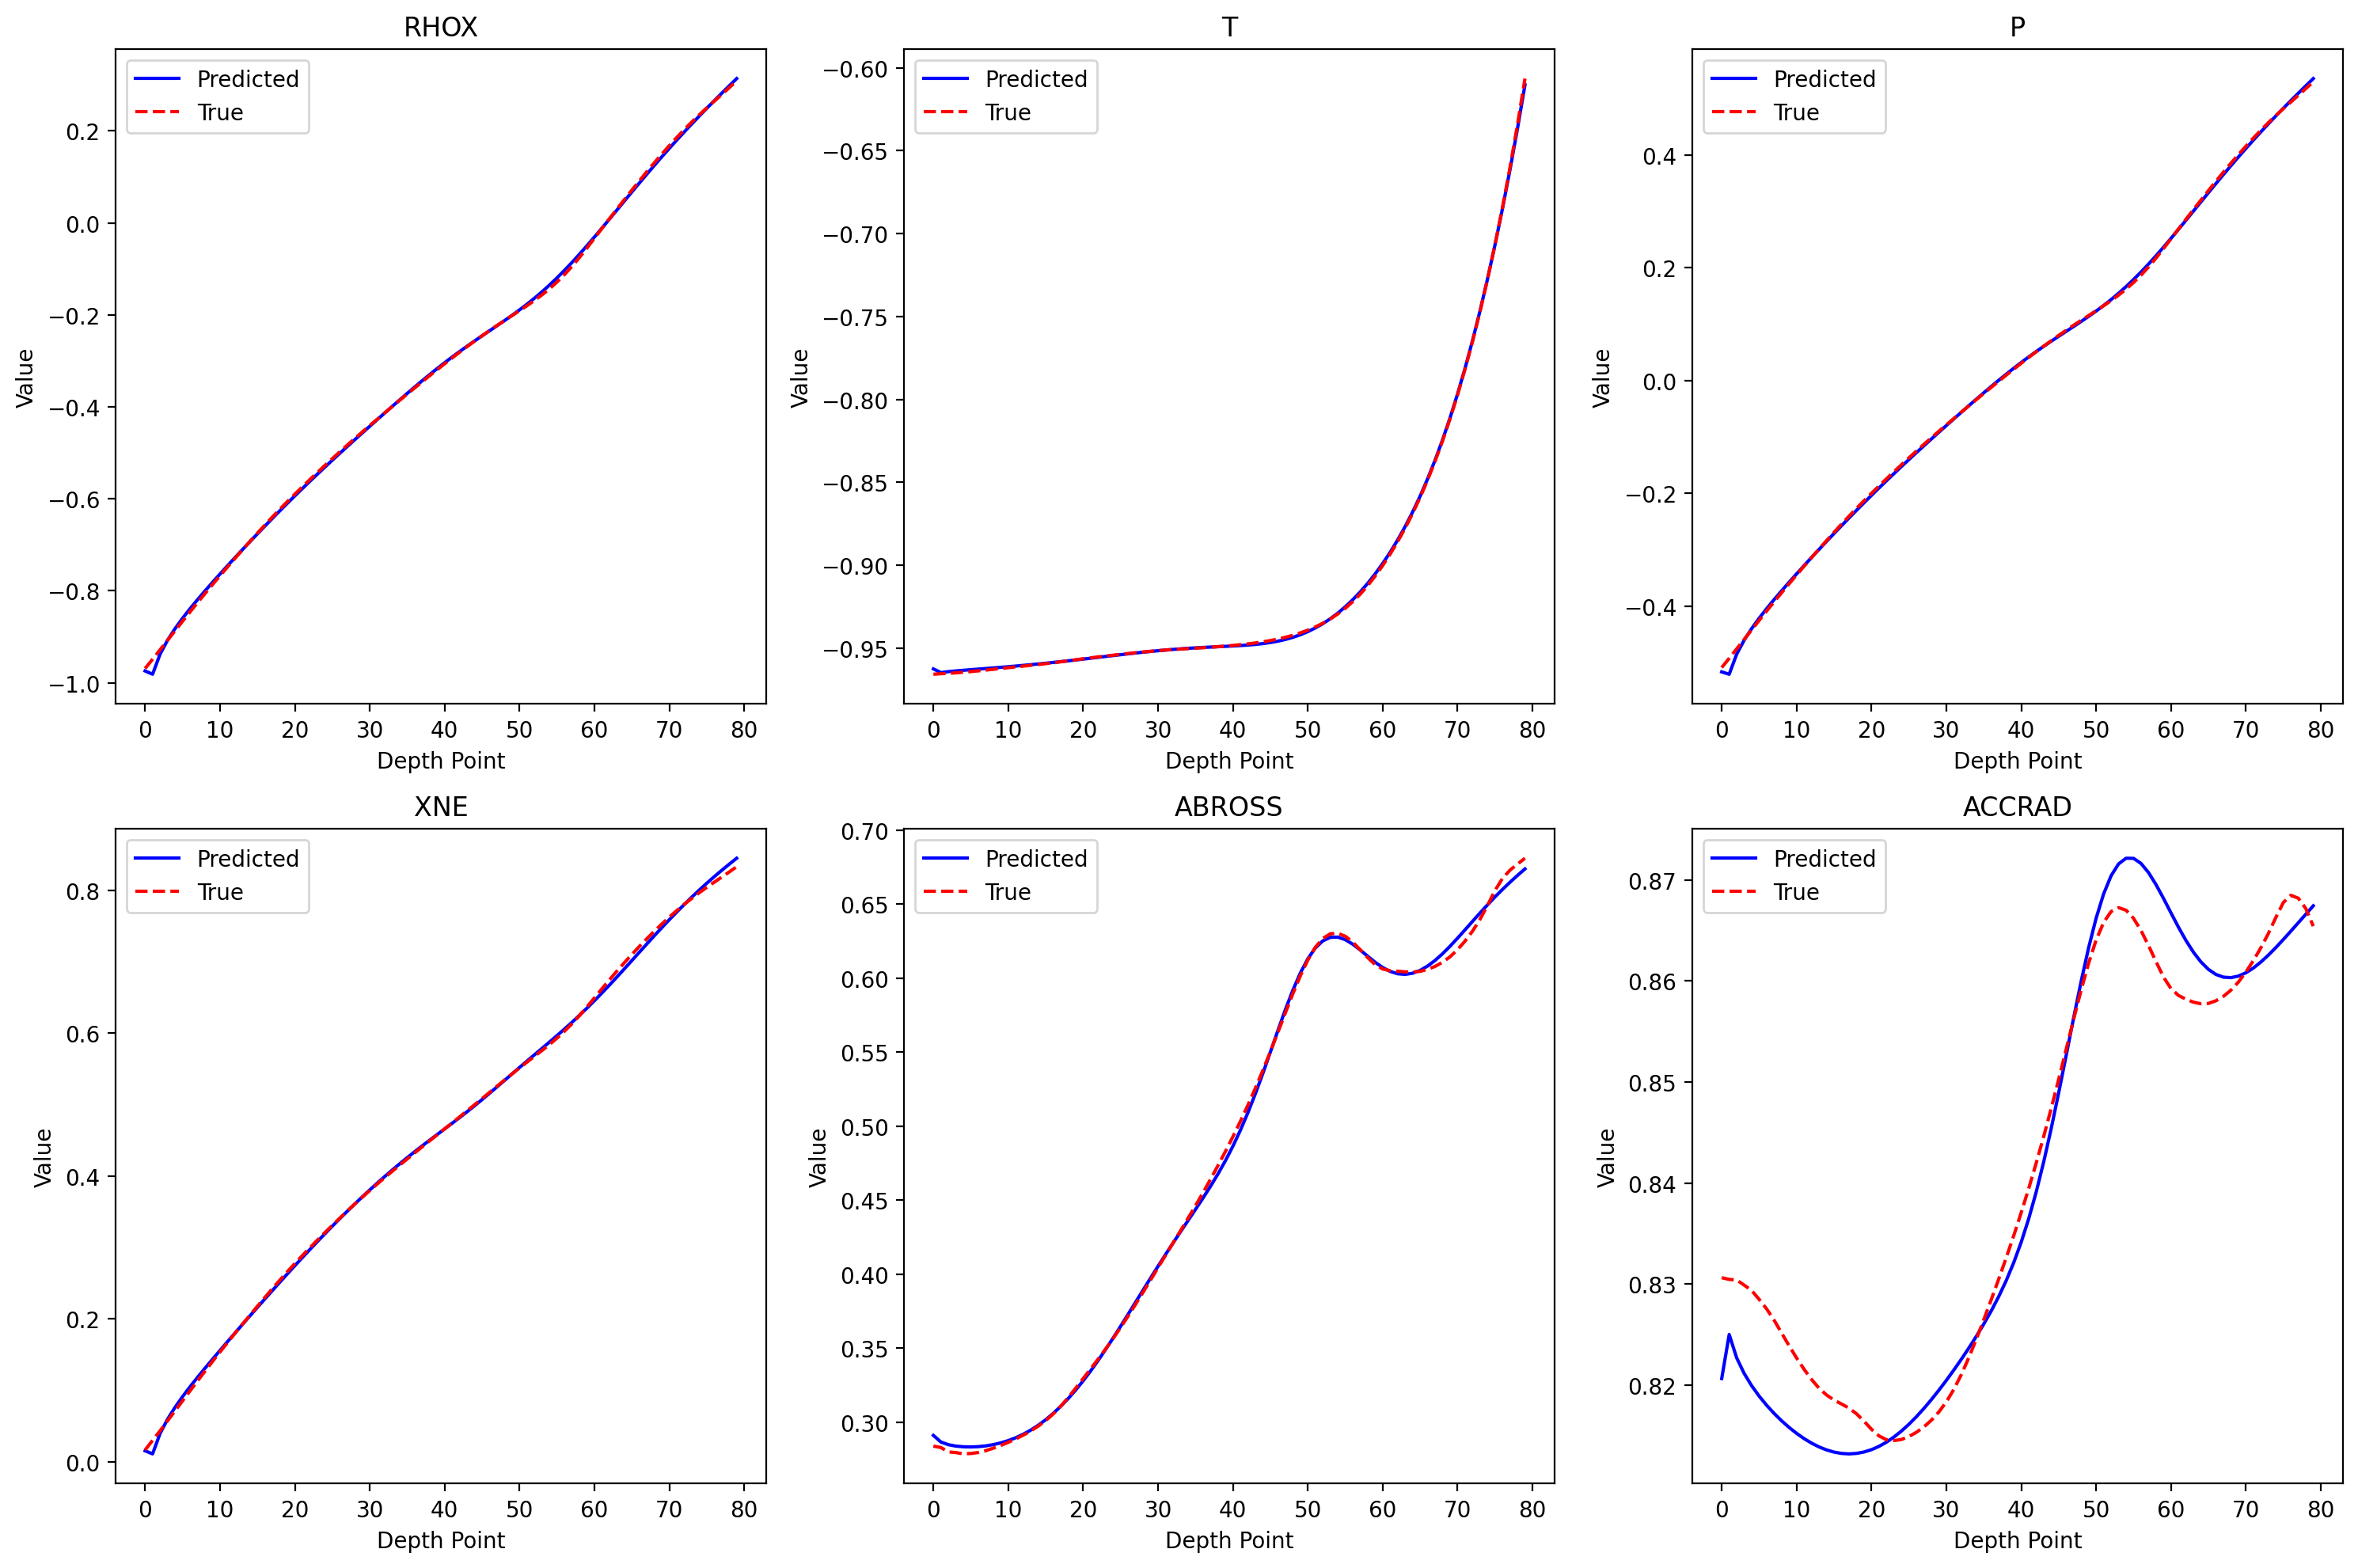

In [ ]:
residual_plot = plot_residuals(predictions, targets)

# Plot a few sample profiles
torch.manual_seed(0)

sample_indices = torch.randperm(predictions.shape[0])[:10]
for idx in sample_indices:
    profile_plot = plot_depth_profile(idx, predictions, targets)

In [55]:
# Example usage:
dP_dtau_ground_truth = calculate_dP_dtau_ground_truth(dataset, sample_indices=sample_indices)
dP_dtau_predicted = calculate_dP_dtau_predicted(model, dataset, sample_indices=sample_indices, device=device)

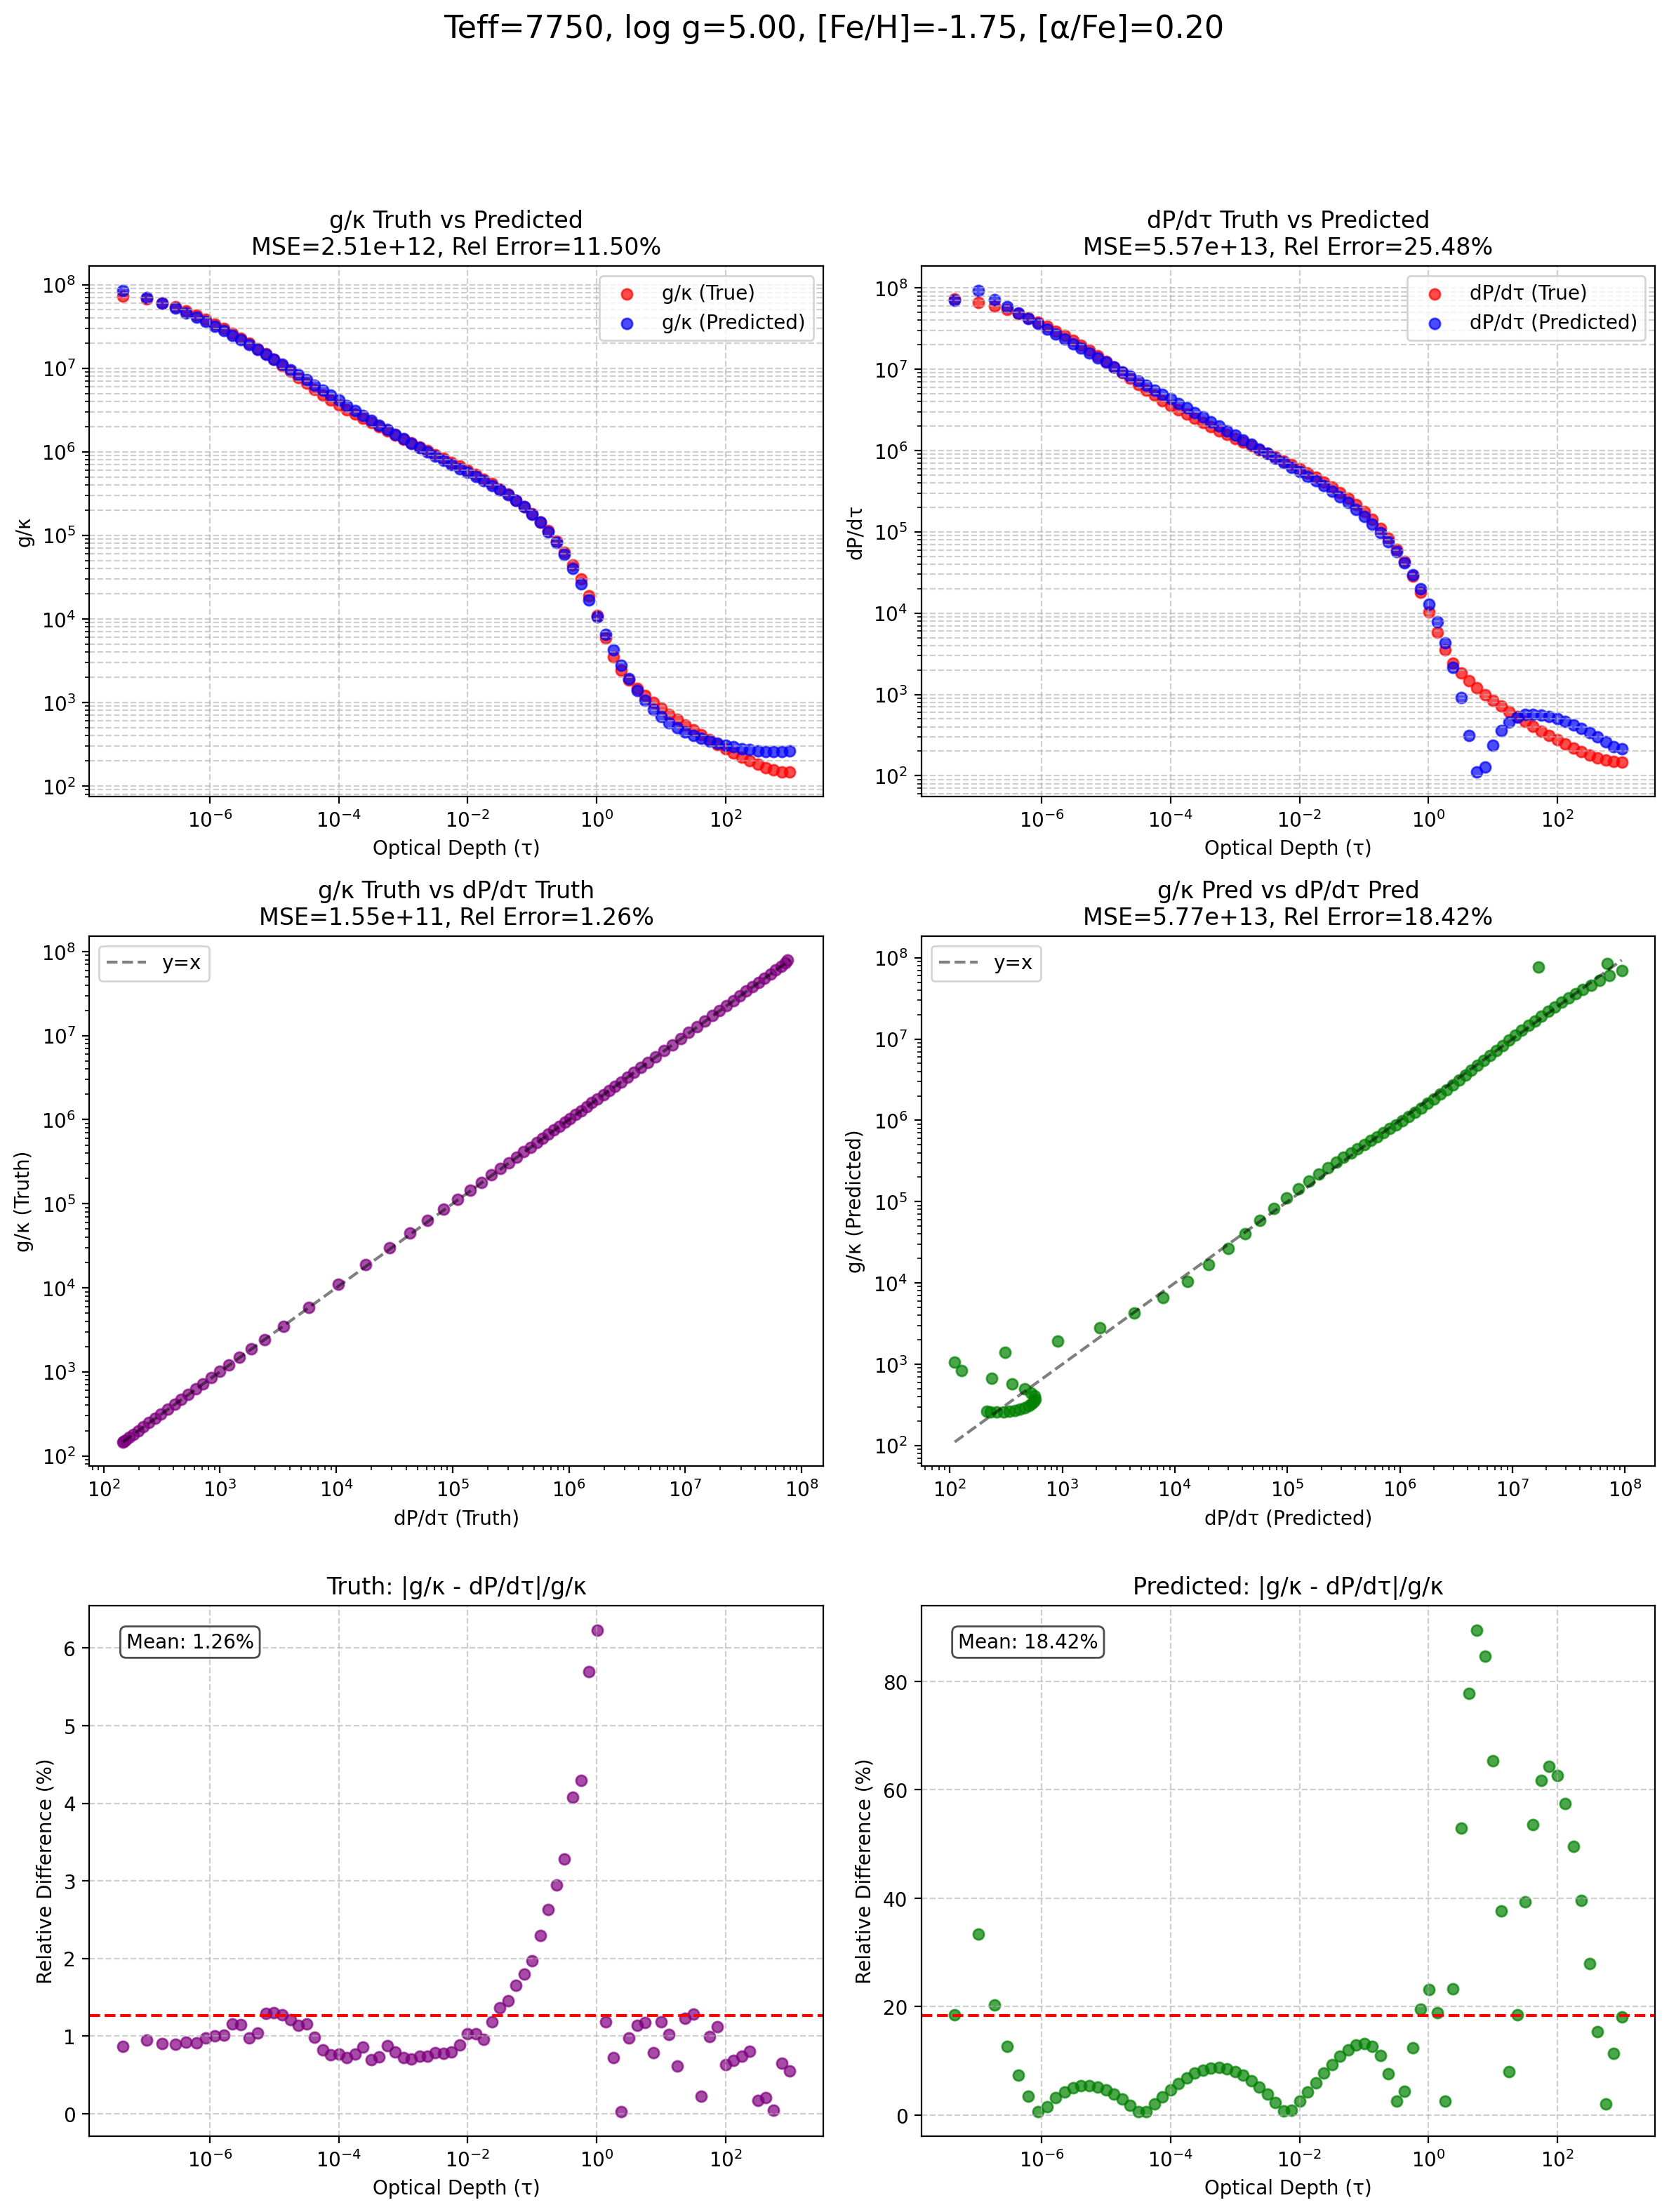

In [57]:
# Example usage:
fig = plot_comprehensive_comparison(dP_dtau_predicted, dP_dtau_ground_truth, sample_idx=3)

# Physical losses


In [90]:
%reload_ext autoreload
%autoreload 2
from physics import hydro_equilibrium_loss

Model loaded: trained for 1000 epochs, final loss: 0.002732
Validation loss: 0.002708
Validation loss hydro: 0.002864
RHOX loss: 0.000432
T loss: 0.000106
P loss: 0.000352
XNE loss: 0.000144
ABROSS loss: 0.001614
ACCRAD loss: 0.000060

RHOX metrics:
MSE: 0.000087
RMSE: 0.009305
MAE: 0.006114
R²: 0.999426

T metrics:
MSE: 0.000011
RMSE: 0.003248
MAE: 0.001764
R²: 0.999480

P metrics:
MSE: 0.000071
RMSE: 0.008411
MAE: 0.005503
R²: 0.999259

XNE metrics:
MSE: 0.000145
RMSE: 0.012027
MAE: 0.007660
R²: 0.998592

ABROSS metrics:
MSE: 0.000162
RMSE: 0.012717
MAE: 0.008306
R²: 0.998642

ACCRAD metrics:
MSE: 0.000059
RMSE: 0.007713
MAE: 0.005527
R²: 0.996847


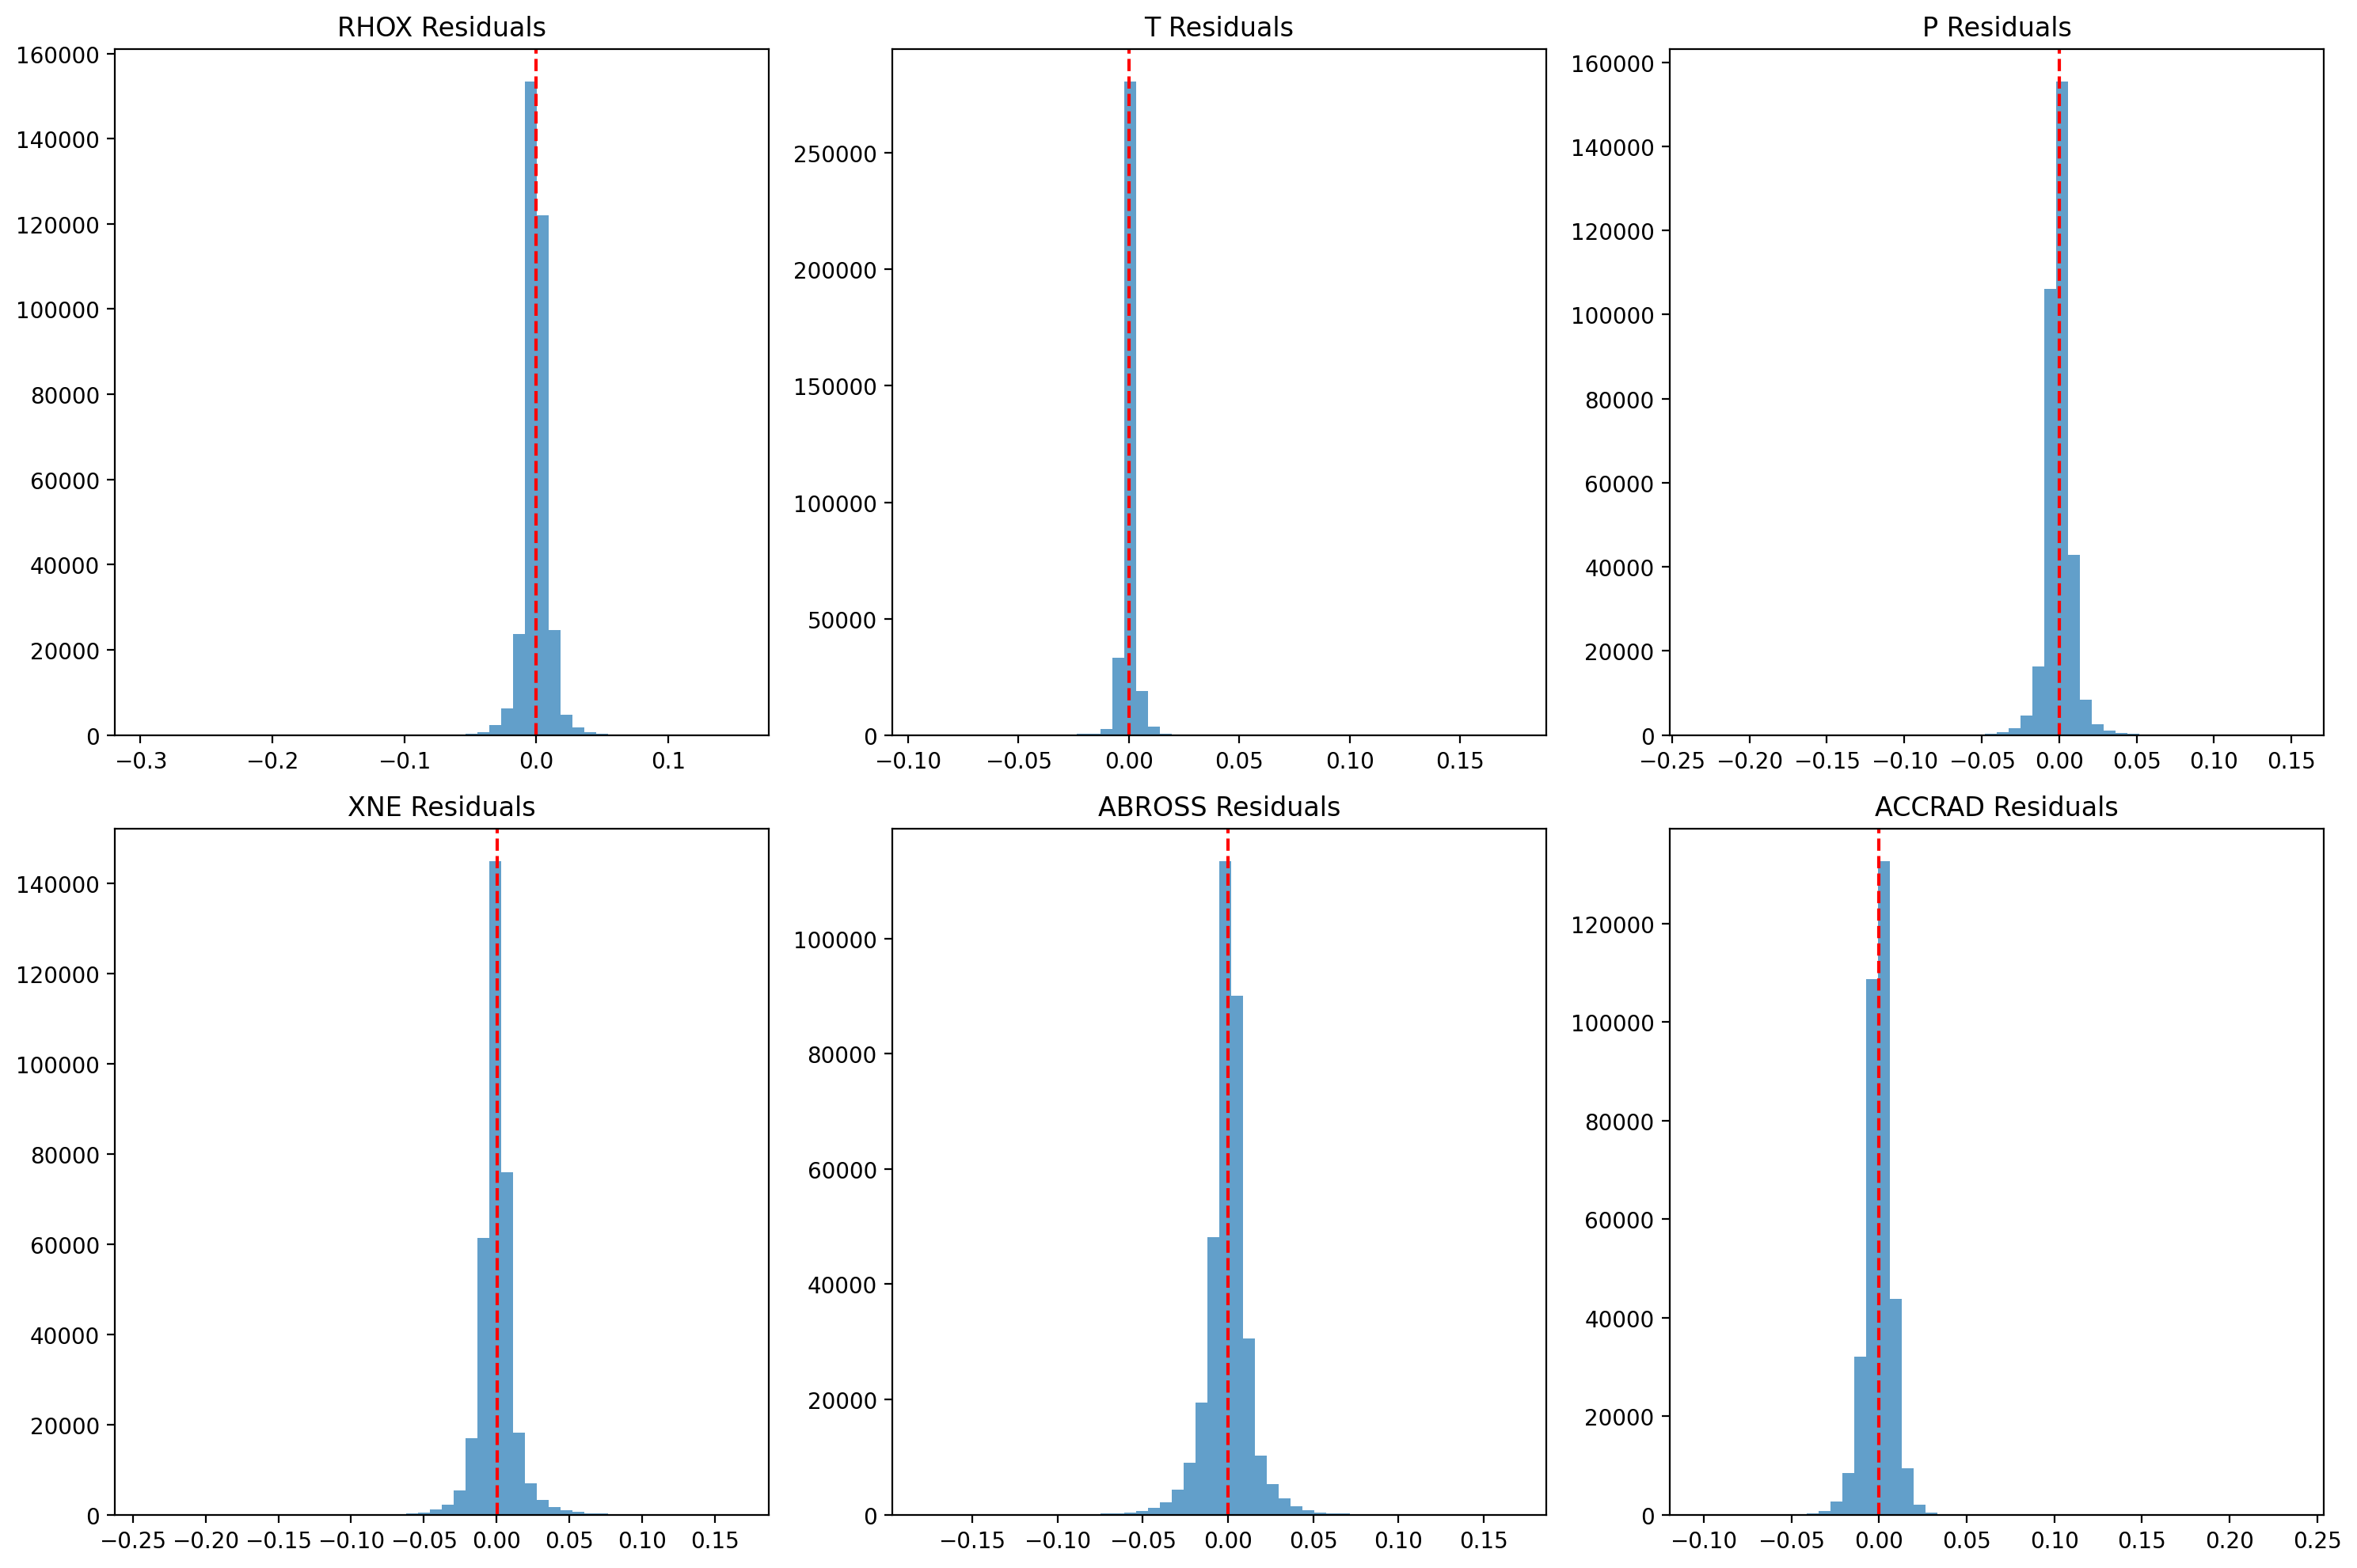

In [53]:
model_path = "/home/jdli/xiasangju/kurucz1/checkpoints_v0327enc/best_model.pt"
model_hytro_path = "/home/jdli/xiasangju/kurucz1/checkpoints_v0327enc_hydro/best_model.pt"
dataset_path = "/home/jdli/xiasangju/kurucz1/data/kurucz_vturb_0p5_tau_v3.pt"

hidden_size = 128
device = torch.device('cpu')

# Load dataset and model
model, epoch, train_loss = load_trained_model(
    model_path, hidden_size, dataset.max_depth_points, device
)
print(f"Model loaded: trained for {epoch} epochs, final loss: {train_loss:.6f}")


model_hydro, epoch_hydro, train_loss_hydro = load_trained_model(
    model_hytro_path, hidden_size, dataset.max_depth_points, device
)

# Validate model
val_loss, param_losses, inputs, predictions, targets = validate_model(model, val_loader, device)
val_loss_hydro, param_losses_hydro, inputs_hydro, predictions_hydro, targets_hydro = validate_model(model_hydro, val_loader, device)
print(f"Validation loss: {val_loss:.6f}")
print(f"Validation loss hydro: {val_loss_hydro:.6f}")
for param, loss in param_losses.items():
    print(f"{param} loss: {loss:.6f}")


# Calculate metrics
metrics = calculate_metrics(predictions, targets)
for param, param_metrics in metrics.items():
    print(f"\n{param} metrics:")

    for metric_name, value in param_metrics.items():
        print(f"{metric_name}: {value:.6f}")

        
residual_plot = plot_residuals(predictions, targets)
# Plot a few sample profiles
torch.manual_seed(0)
sample_indices = torch.randperm(predictions.shape[0])[:10]

In [54]:
# random seed
torch.manual_seed(0)
sample_indices = torch.randperm(predictions.shape[0])[:10]

dP_dtau_ground_truth    = calculate_dP_dtau_ground_truth(dataset, sample_indices=sample_indices)
dP_dtau_predicted       = calculate_dP_dtau_predicted(model, dataset, sample_indices=sample_indices, device=device)
dP_dtau_predicted_hydro = calculate_dP_dtau_predicted(model_hydro, dataset, sample_indices=sample_indices, device=device)


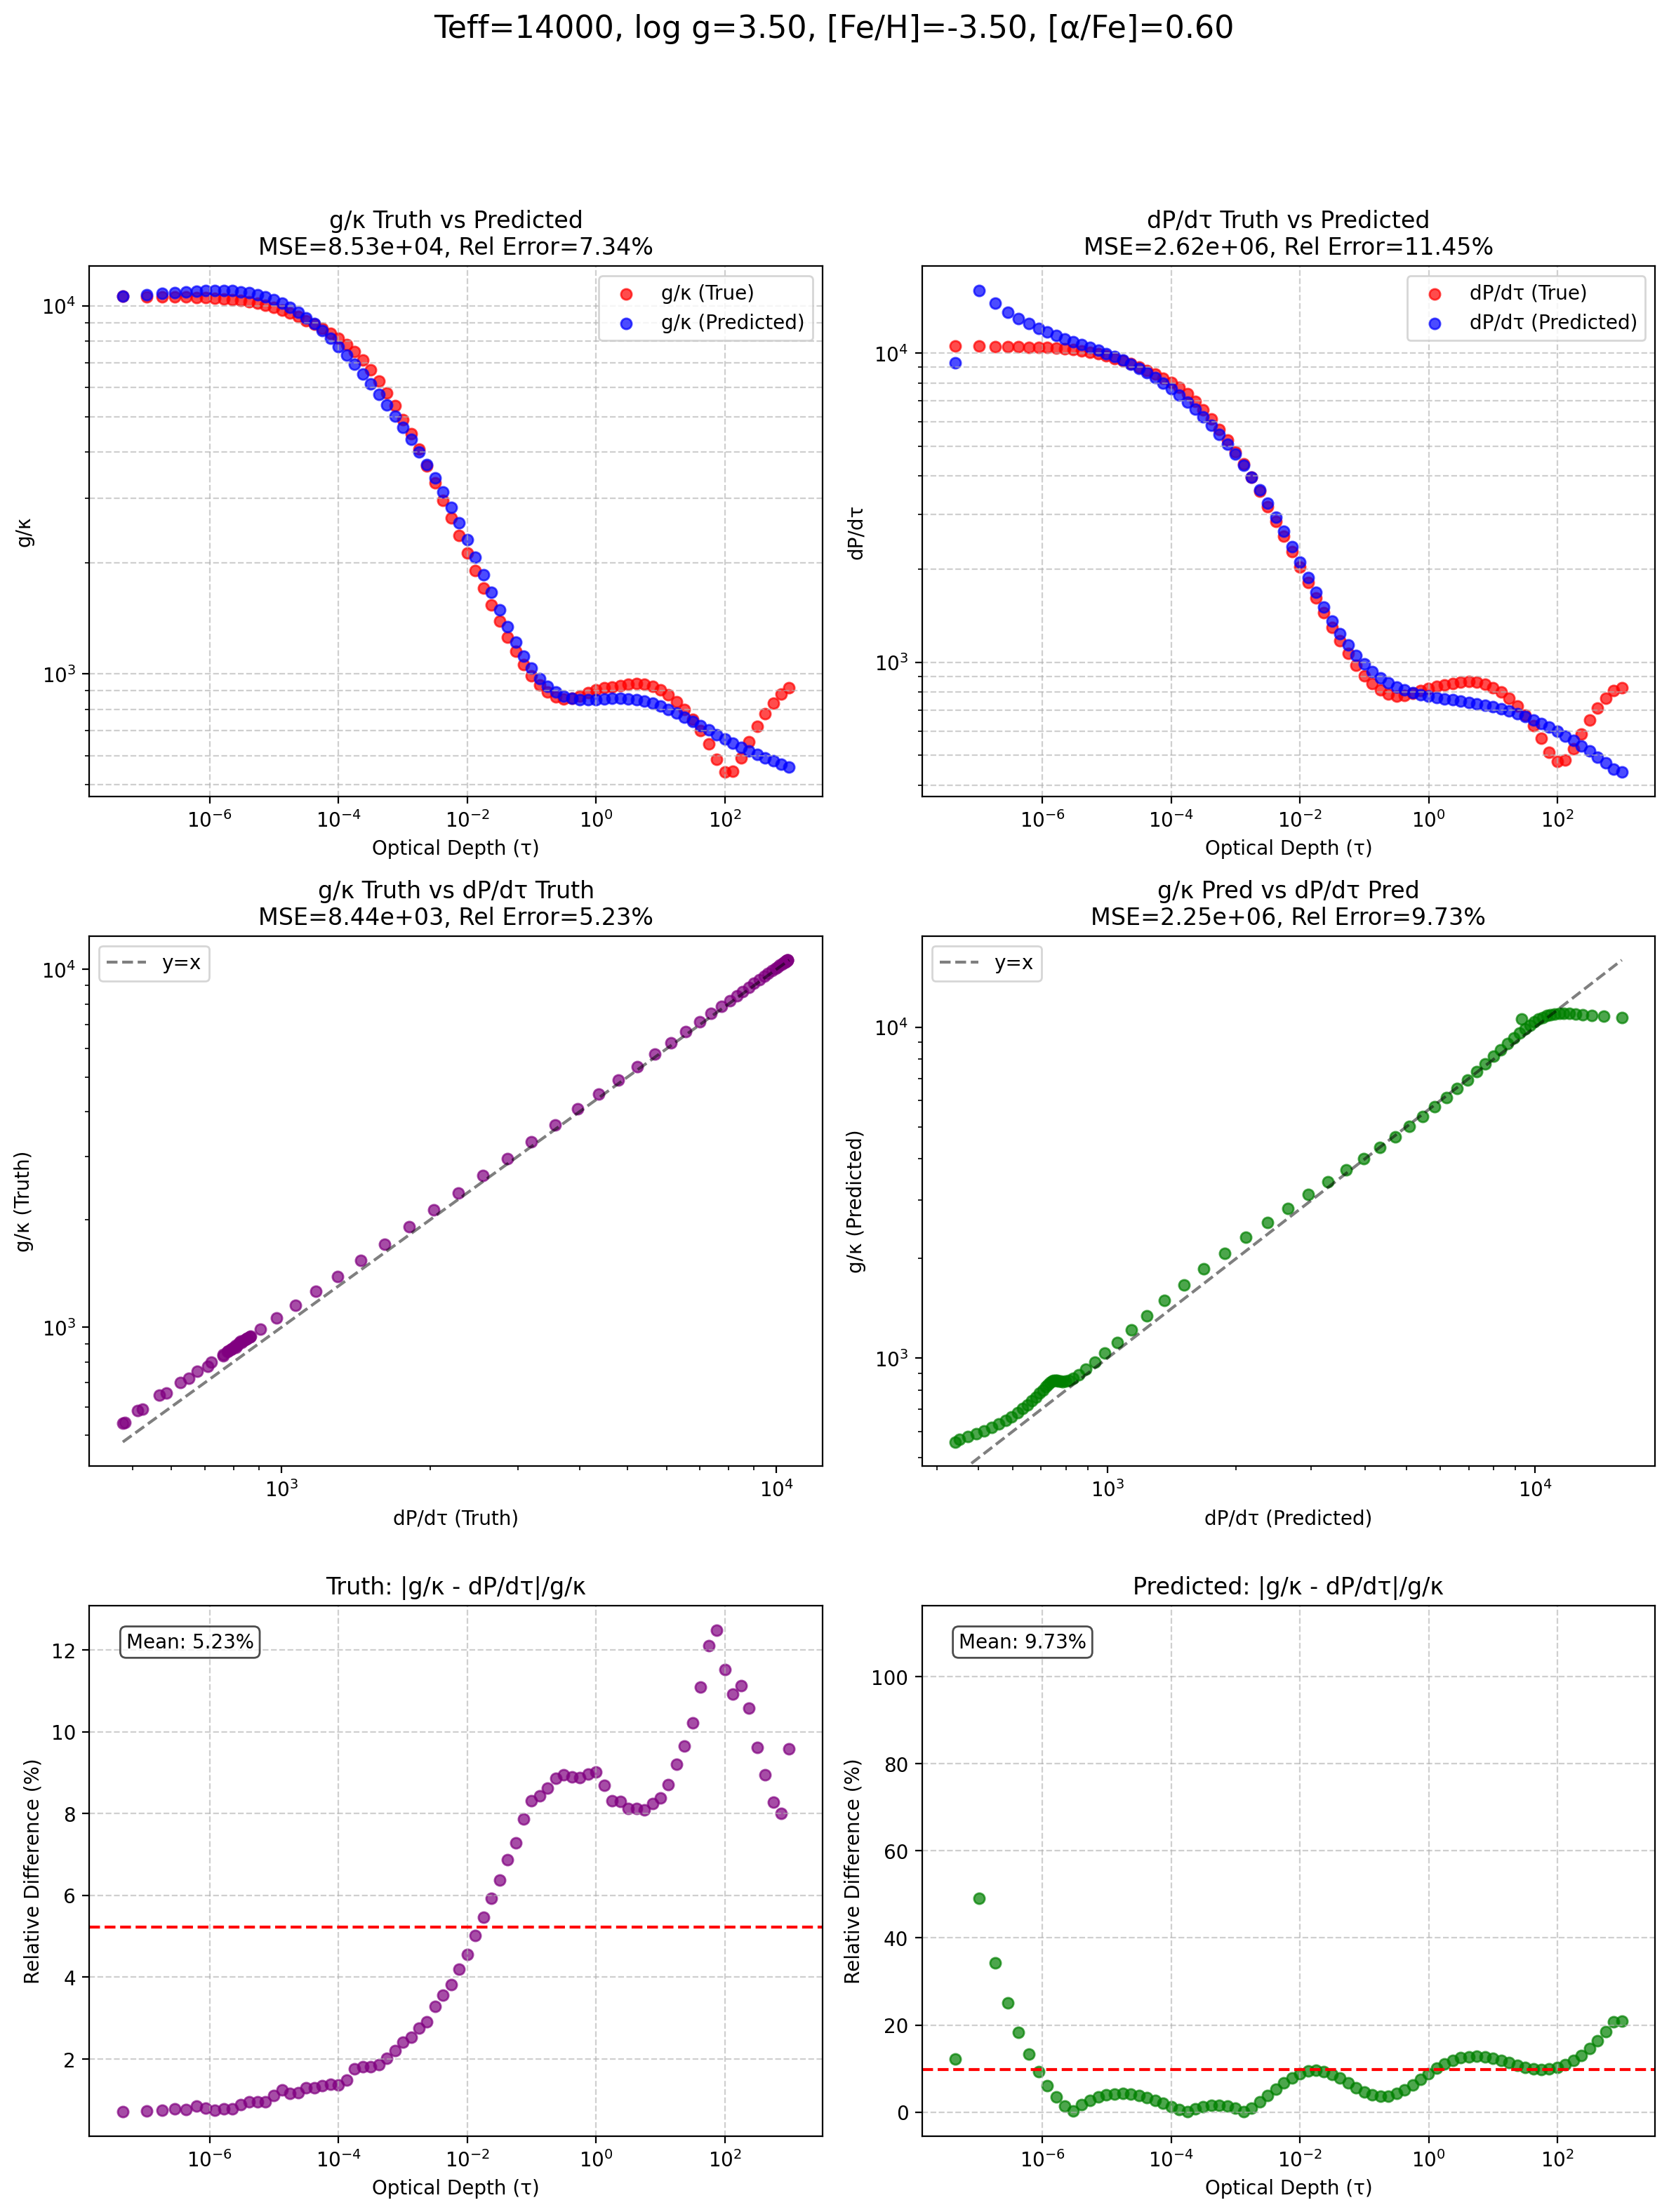

In [68]:
fig = plot_comprehensive_comparison(dP_dtau_predicted, dP_dtau_ground_truth, sample_idx=6)


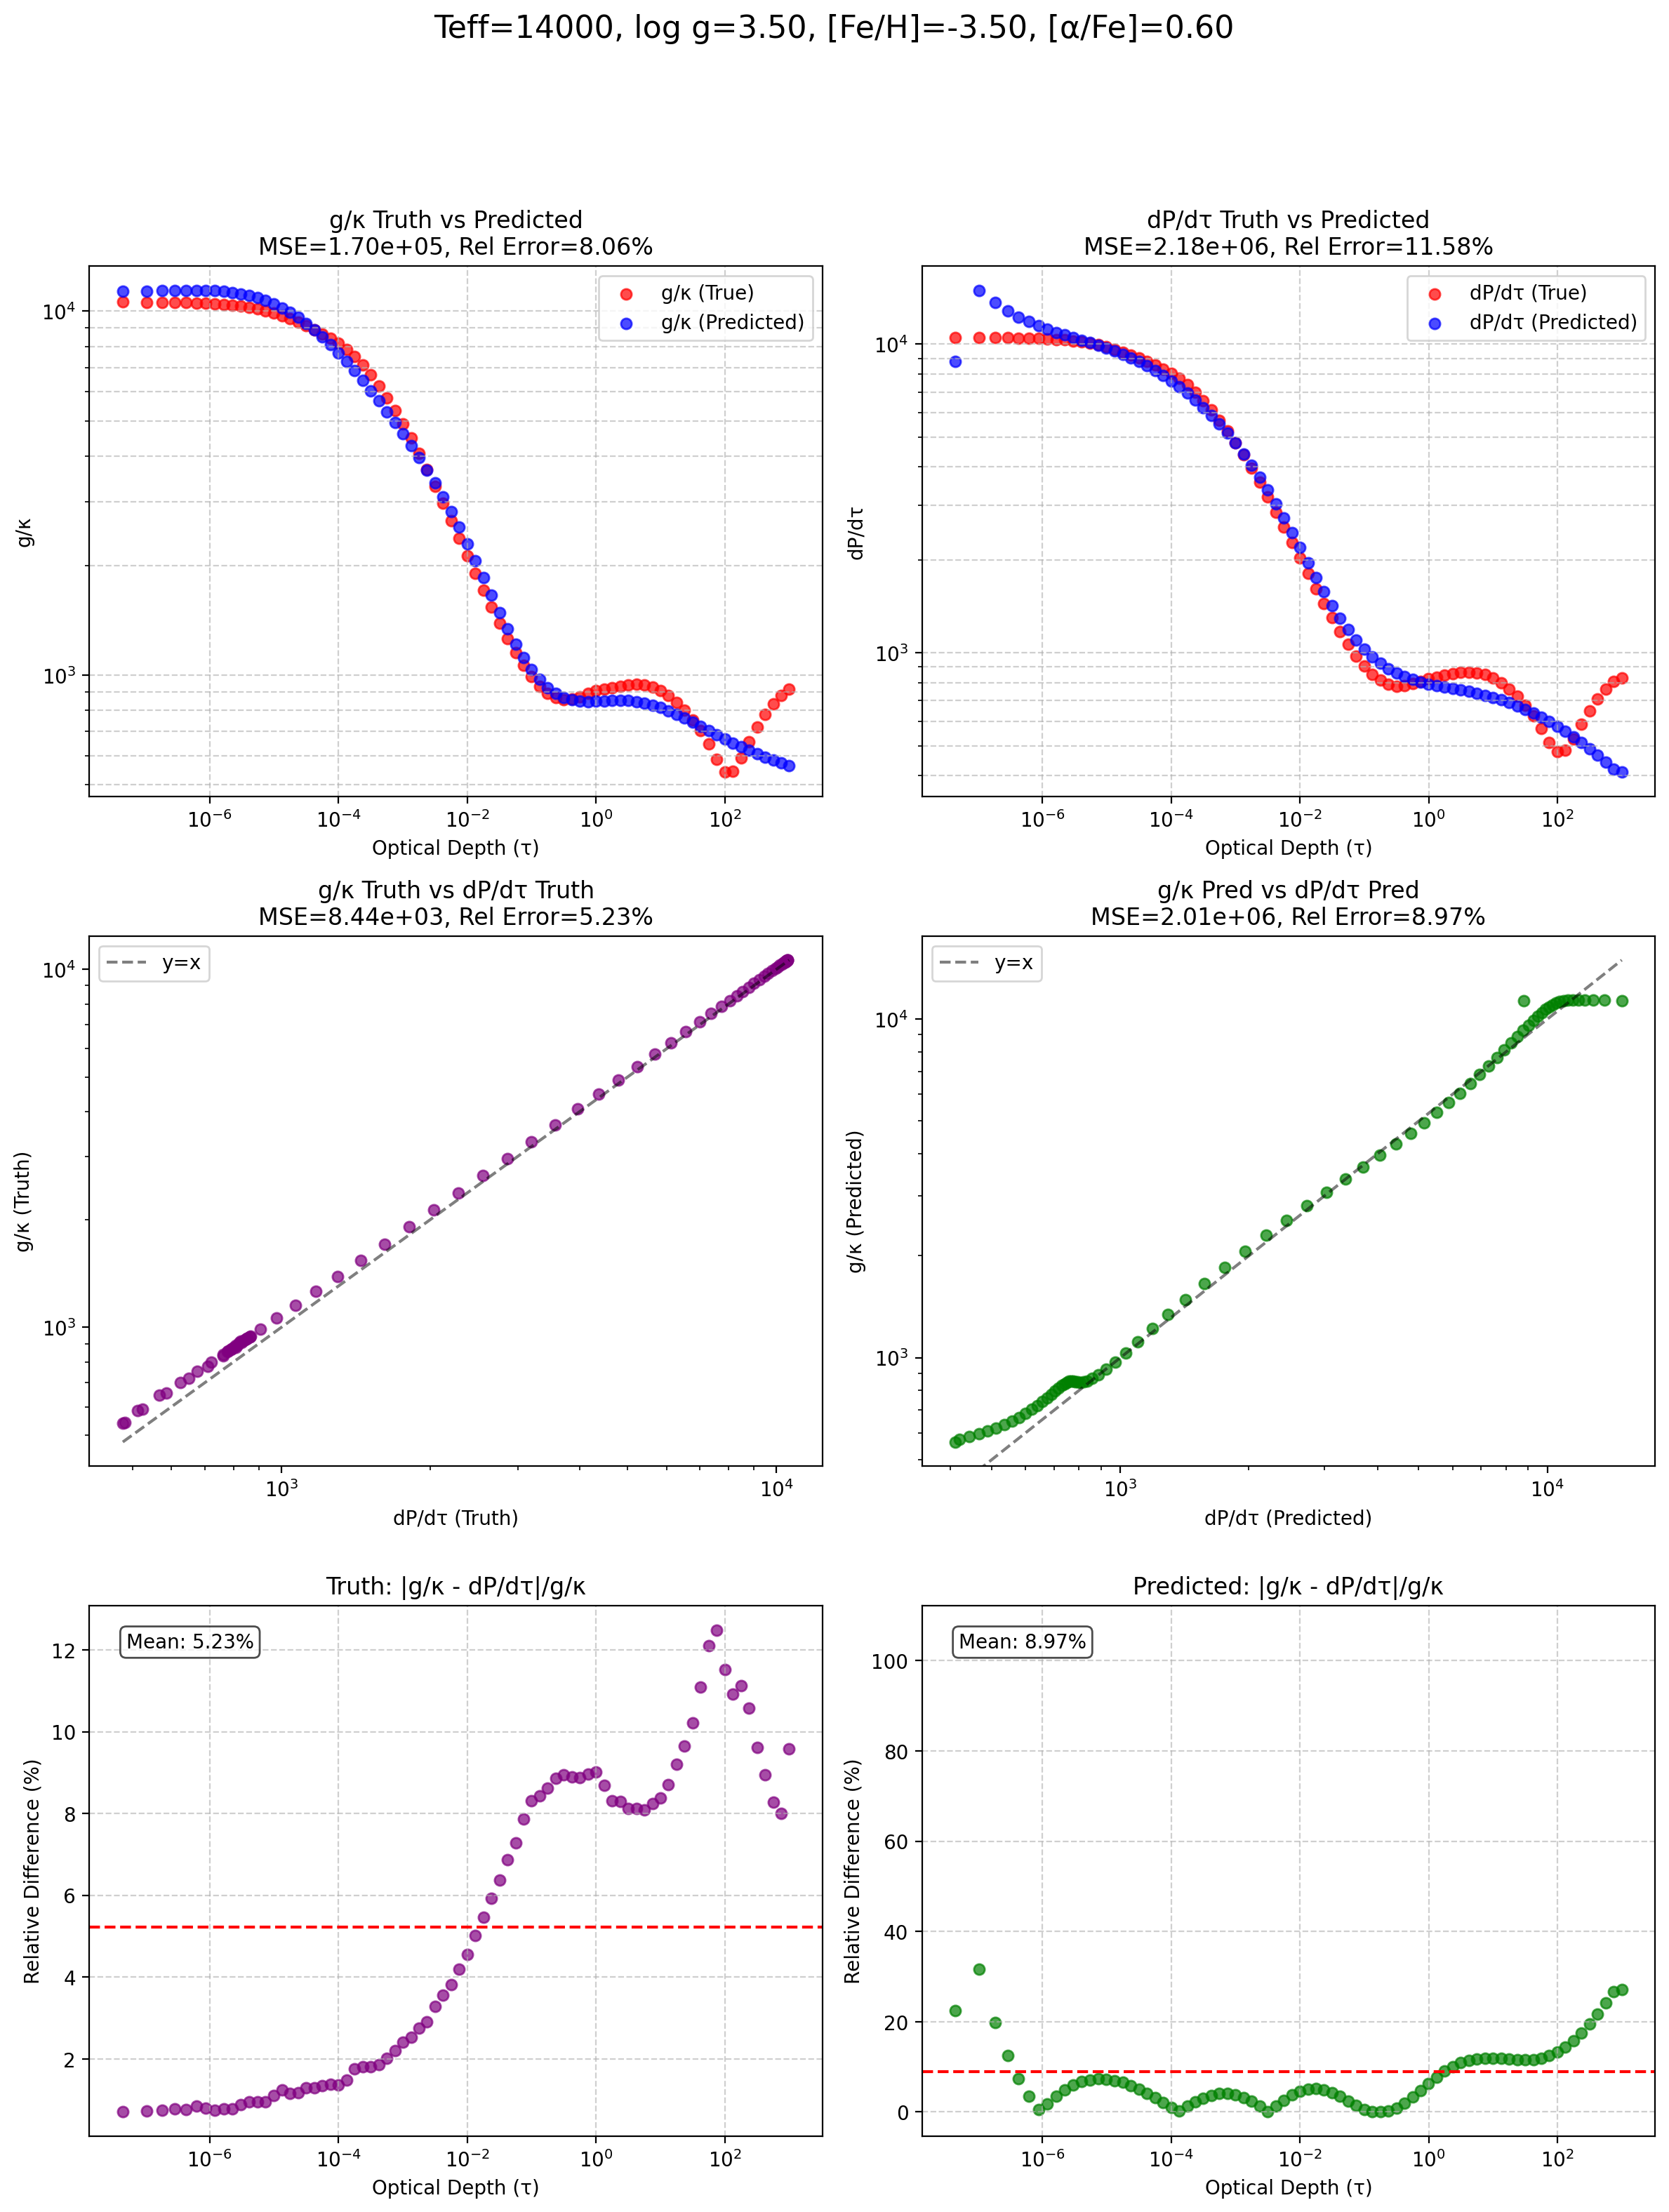

In [69]:
fig = plot_comprehensive_comparison(dP_dtau_predicted_hydro, dP_dtau_ground_truth, sample_idx=6)

In [59]:
def hydro_equilibrium_loss(outputs, inputs, dataset, model, is_training=True):
    """
    Calculate hydrostatic equilibrium physics-informed loss
    
    Args:
        outputs (torch.Tensor): Model outputs (normalized)
        inputs (torch.Tensor): Model inputs
        dataset (KuruczDataset): Dataset object containing normalization parameters
        model (nn.Module): The neural network model
        is_training (bool): Whether we're in training mode
    
    Returns:
        torch.Tensor: Computed physics loss
    """
    # Constants for numerical stability and gradient clipping
    GRAD_CLIP = 1e3
    SAFE_LOG = 1e-30
    
    # ===== Parameter indices =====
    P_idx = 2        # Pressure index in output (3rd parameter)
    ABROSS_idx = 4    # ABROSS index in output (5th parameter)
    TAU_START = 4     # Starting index of tau parameters in input

    # ===== 1. Data Preparation =====
    p_params = dataset.norm_params['P']
    tau_params = dataset.norm_params['TAU']
    
    # Create inputs that require gradients
    grad_inputs = inputs.detach().clone()
    grad_inputs.requires_grad_(True)

    # ===== 2. Gradient Calculation =====
    # Temporarily set model to eval/train mode as needed
    original_training = model.training
    if is_training:
        model.train()
    else:
        model.eval()
        
    # Forward pass through the model
    model_outputs = model(grad_inputs)  # Output shape: (n_batch, 6, 80)
    P_norm = model_outputs[:, :, P_idx]  # [batch, depth]

    # Compute gradients
    grad_outputs = torch.ones_like(P_norm)
    try:
        gradients = torch.autograd.grad(
            outputs=P_norm,
            inputs=grad_inputs,
            grad_outputs=grad_outputs,
            create_graph=is_training,
            retain_graph=True,
            allow_unused=False
        )[0]
    
        # Extract tau gradients and clamp
        dlogP_norm_dlogtau_norm = gradients[:, TAU_START:TAU_START+80]
        dlogP_norm_dlogtau_norm = torch.clamp(dlogP_norm_dlogtau_norm, -GRAD_CLIP, GRAD_CLIP)

        # ===== 3. Physical Conversion =====
        logtau = (grad_inputs[:, TAU_START:TAU_START+80] * tau_params['scale'] 
                + (tau_params['min'] + tau_params['max'])/2)
        logP = (P_norm * p_params['scale'] 
            + (p_params['min'] + p_params['max'])/2)
        
        scale_ratio = p_params['scale'] / tau_params['scale']
        dlogP_dlogtau = dlogP_norm_dlogtau_norm * scale_ratio
        
        # Improved numerical stability in logarithm
        eps_mask = dlogP_dlogtau.abs() < SAFE_LOG
        safe_dlogP = dlogP_dlogtau.clone()
        safe_dlogP[eps_mask] = torch.sign(safe_dlogP[eps_mask]) * SAFE_LOG
        log_dP_dtau = logP - logtau + torch.log10(safe_dlogP.abs())

    except RuntimeError as e:
        if is_training:
            # During training, re-raise the error for debugging
            raise RuntimeError(f"Gradient calculation failed during training: {e}")
        else:
            # During validation/inference, log warning and return zero loss
            print(f"[WARNING] d(logP)/d(tau) gradient calculation failed: {e}")
            # Restore model state and return zero loss
            model.train(original_training)
            return torch.tensor(0.0, device=outputs.device)

    # ===== 4. Equilibrium Condition =====
    ABROSS_norm = torch.clamp(outputs[:, :, ABROSS_idx], -5.0, 5.0)
    kappa = dataset.denormalize('ABROSS', ABROSS_norm)
    log_kappa = torch.log10(torch.clamp(kappa, min=SAFE_LOG))
    
    logg = dataset.denormalize('gravity', inputs[:, 1])
    logg = torch.clamp(logg, -1, 6).unsqueeze(-1)

    term_left = log_dP_dtau     # (n_batch, 80)
    term_right = logg - log_kappa  # (n_batch, 80)

    # ===== 5. Modified Loss Calculation =====
    valid_mask = torch.isfinite(term_left) & torch.isfinite(term_right)
    
    # Create depth exclusion mask
    depth_mask = torch.ones_like(term_left, dtype=torch.bool)
    depth_mask[:, :1] = False    # Exclude first 1 depth points
    depth_mask[:, -21] = False   # Exclude last  1 depth points
    final_mask = valid_mask & depth_mask

    # Handle empty masks properly
    if not final_mask.any():
        # Restore model state
        model.train(original_training)
        # Return a small non-zero loss to maintain gradient flow
        return torch.tensor(1e-6, device=outputs.device, requires_grad=True)
    
    # Main MSE loss between terms
    mse_loss = F.mse_loss(term_left[final_mask], term_right[final_mask])
    
    # Reinclude physics sign constraint (gradient should have correct sign)
    # Pressure should increase with optical depth
    sign_loss = F.relu(-dlogP_dlogtau * torch.sign(term_right.detach())).mean()
    
    # Combine losses
    total_loss = mse_loss + 0.1 * sign_loss
    
    # Restore original model state
    model.train(original_training)
    
    return total_loss, term_left.detach(), term_right.detach()

def plot_hydro_terms(log_deriv_term, log_rhs, sample_idx=0):
    """
    绘制流体静力学平衡项的对比图
    
    参数:
    - log_deriv_term: (batch_size, depth_points) 对数压力梯度项
    - log_rhs: (batch_size, depth_points) 对数重力/不透明度项
    - sample_idx: 要绘制的批次样本索引
    """
    deriv = log_deriv_term[sample_idx].cpu().numpy()
    rhs = log_rhs[sample_idx].cpu().numpy()
    depth_points = np.arange(len(deriv))
    
    plt.figure(figsize=(12, 6))
    
    # 绘制两条曲线
    plt.plot(depth_points, deriv, 'b-', label='log(dP/dτ)', linewidth=2)
    plt.plot(depth_points, rhs, 'r--', label='log(g/κ)', linewidth=2)
    
    # 计算并填充差异区域
    diff = deriv - rhs
    # 标记和装饰
    plt.title("Hydrostatic Equilibrium Terms Comparison")
    plt.xlabel("Depth Point Index")
    plt.ylabel("Logarithmic Value")
    plt.legend()    
    # 添加平均差异标注
    avg_diff = np.mean(diff)
    plt.annotate(f'Avg Difference: {avg_diff:.3f}', 
                xy=(0.05, 0.9), xycoords='axes fraction',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.ylim(1, 10)
    plt.tight_layout()

# 在训练循环中:
loss_true, log_deriv_true, log_rhs_true = hydro_equilibrium_loss(targets[:10,:,:], inputs[:10,:], dataset, model)
loss, log_deriv, log_rhs = hydro_equilibrium_loss(predictions[:10,:,:], inputs[:10,:], dataset, model)
loss_hydro, log_deriv_hydro, log_rhs_hydro = hydro_equilibrium_loss(predictions_hydro[:10,:,:], inputs[:10,:], dataset, model_hydro)

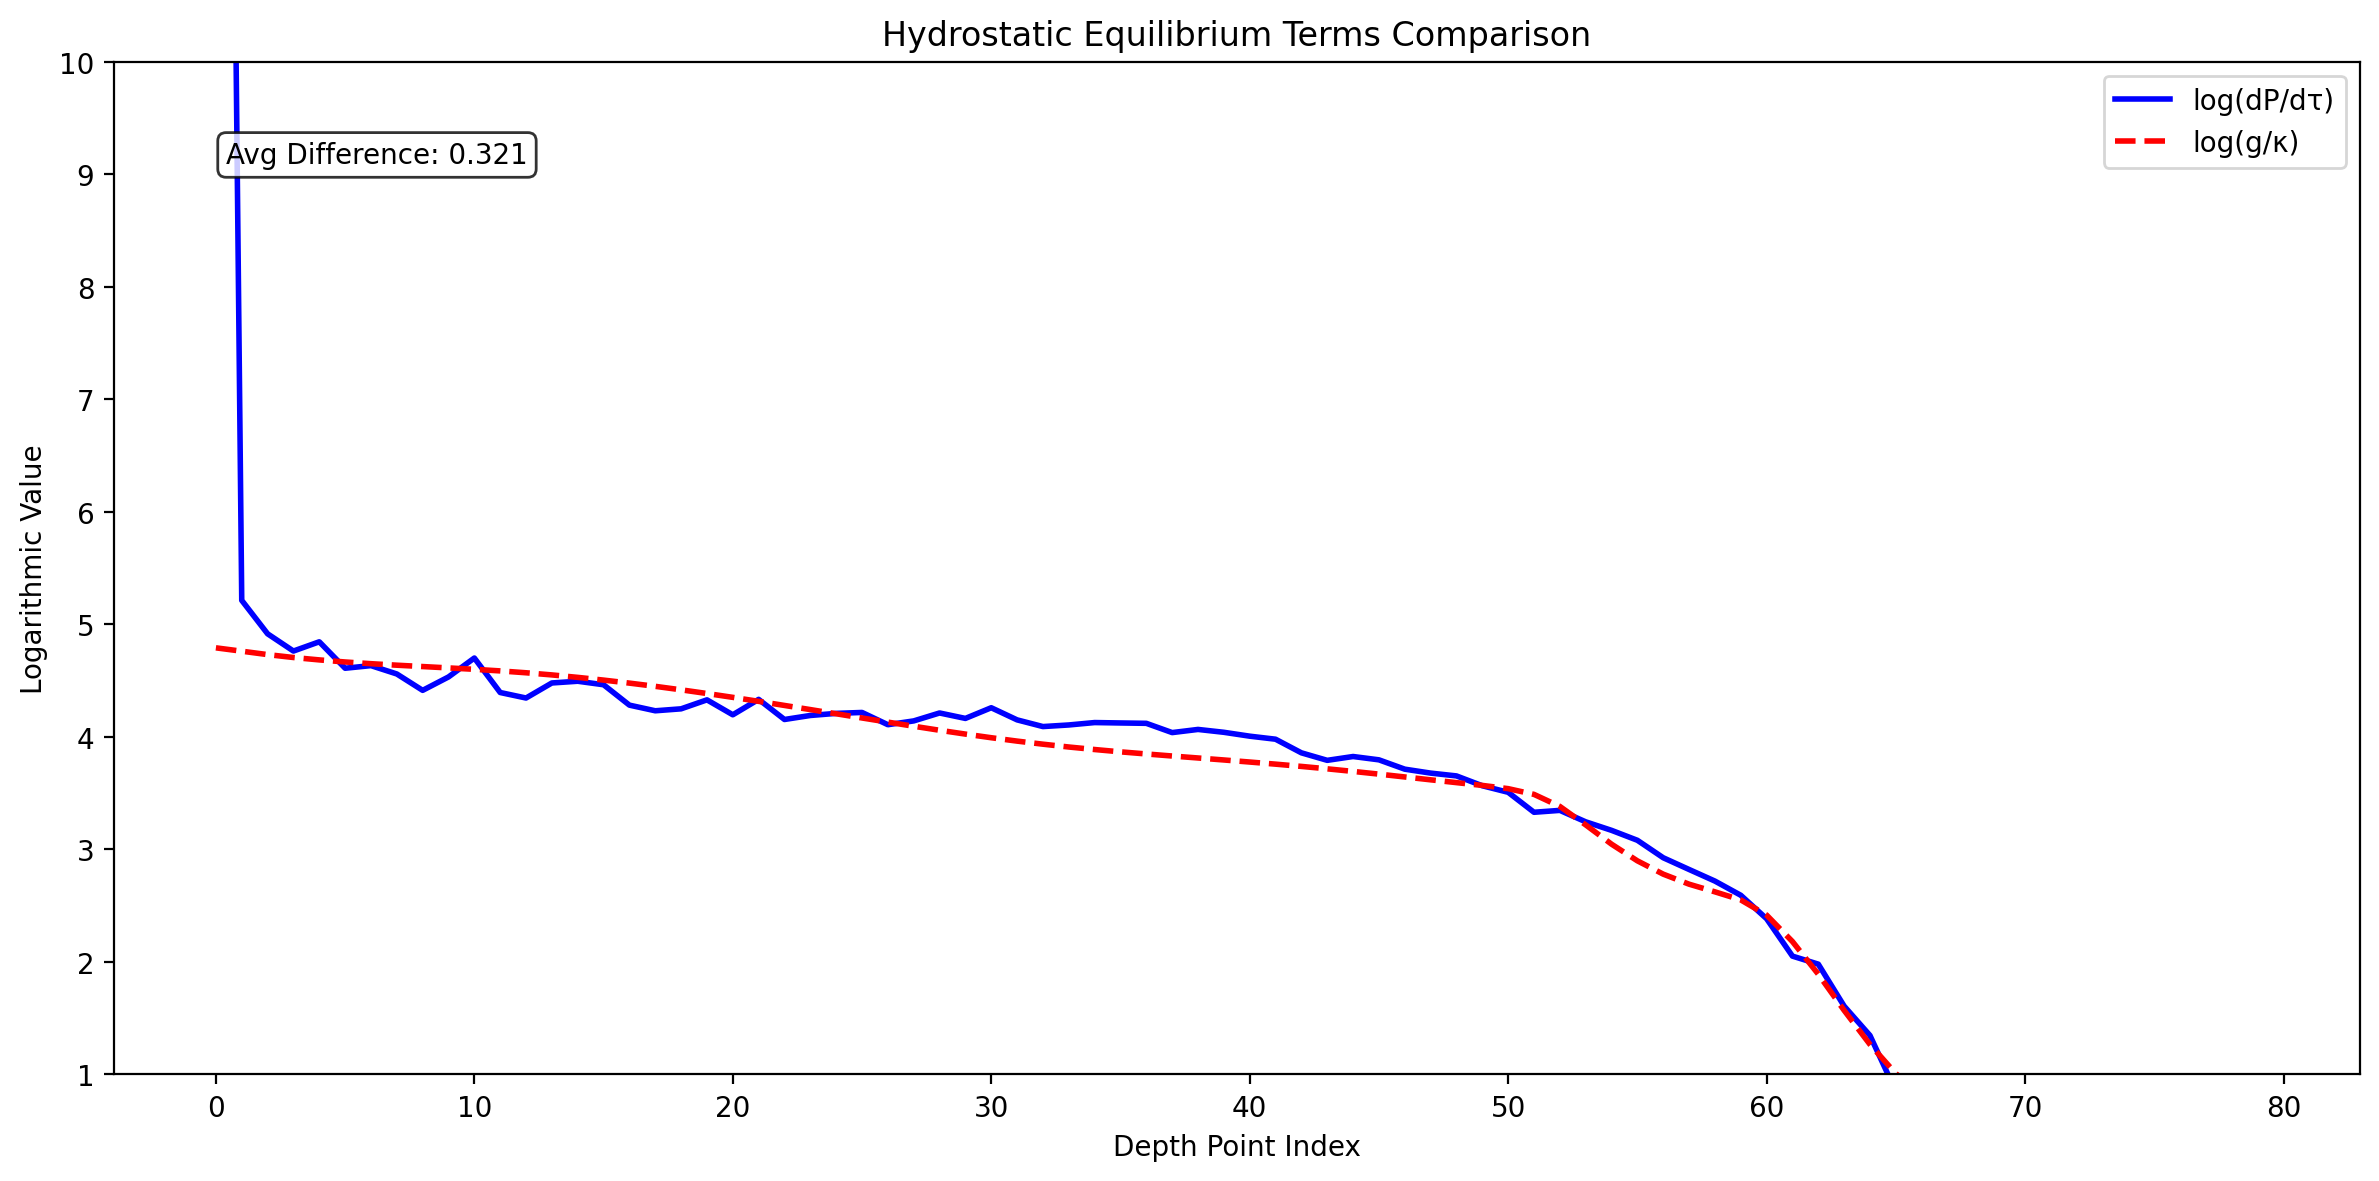

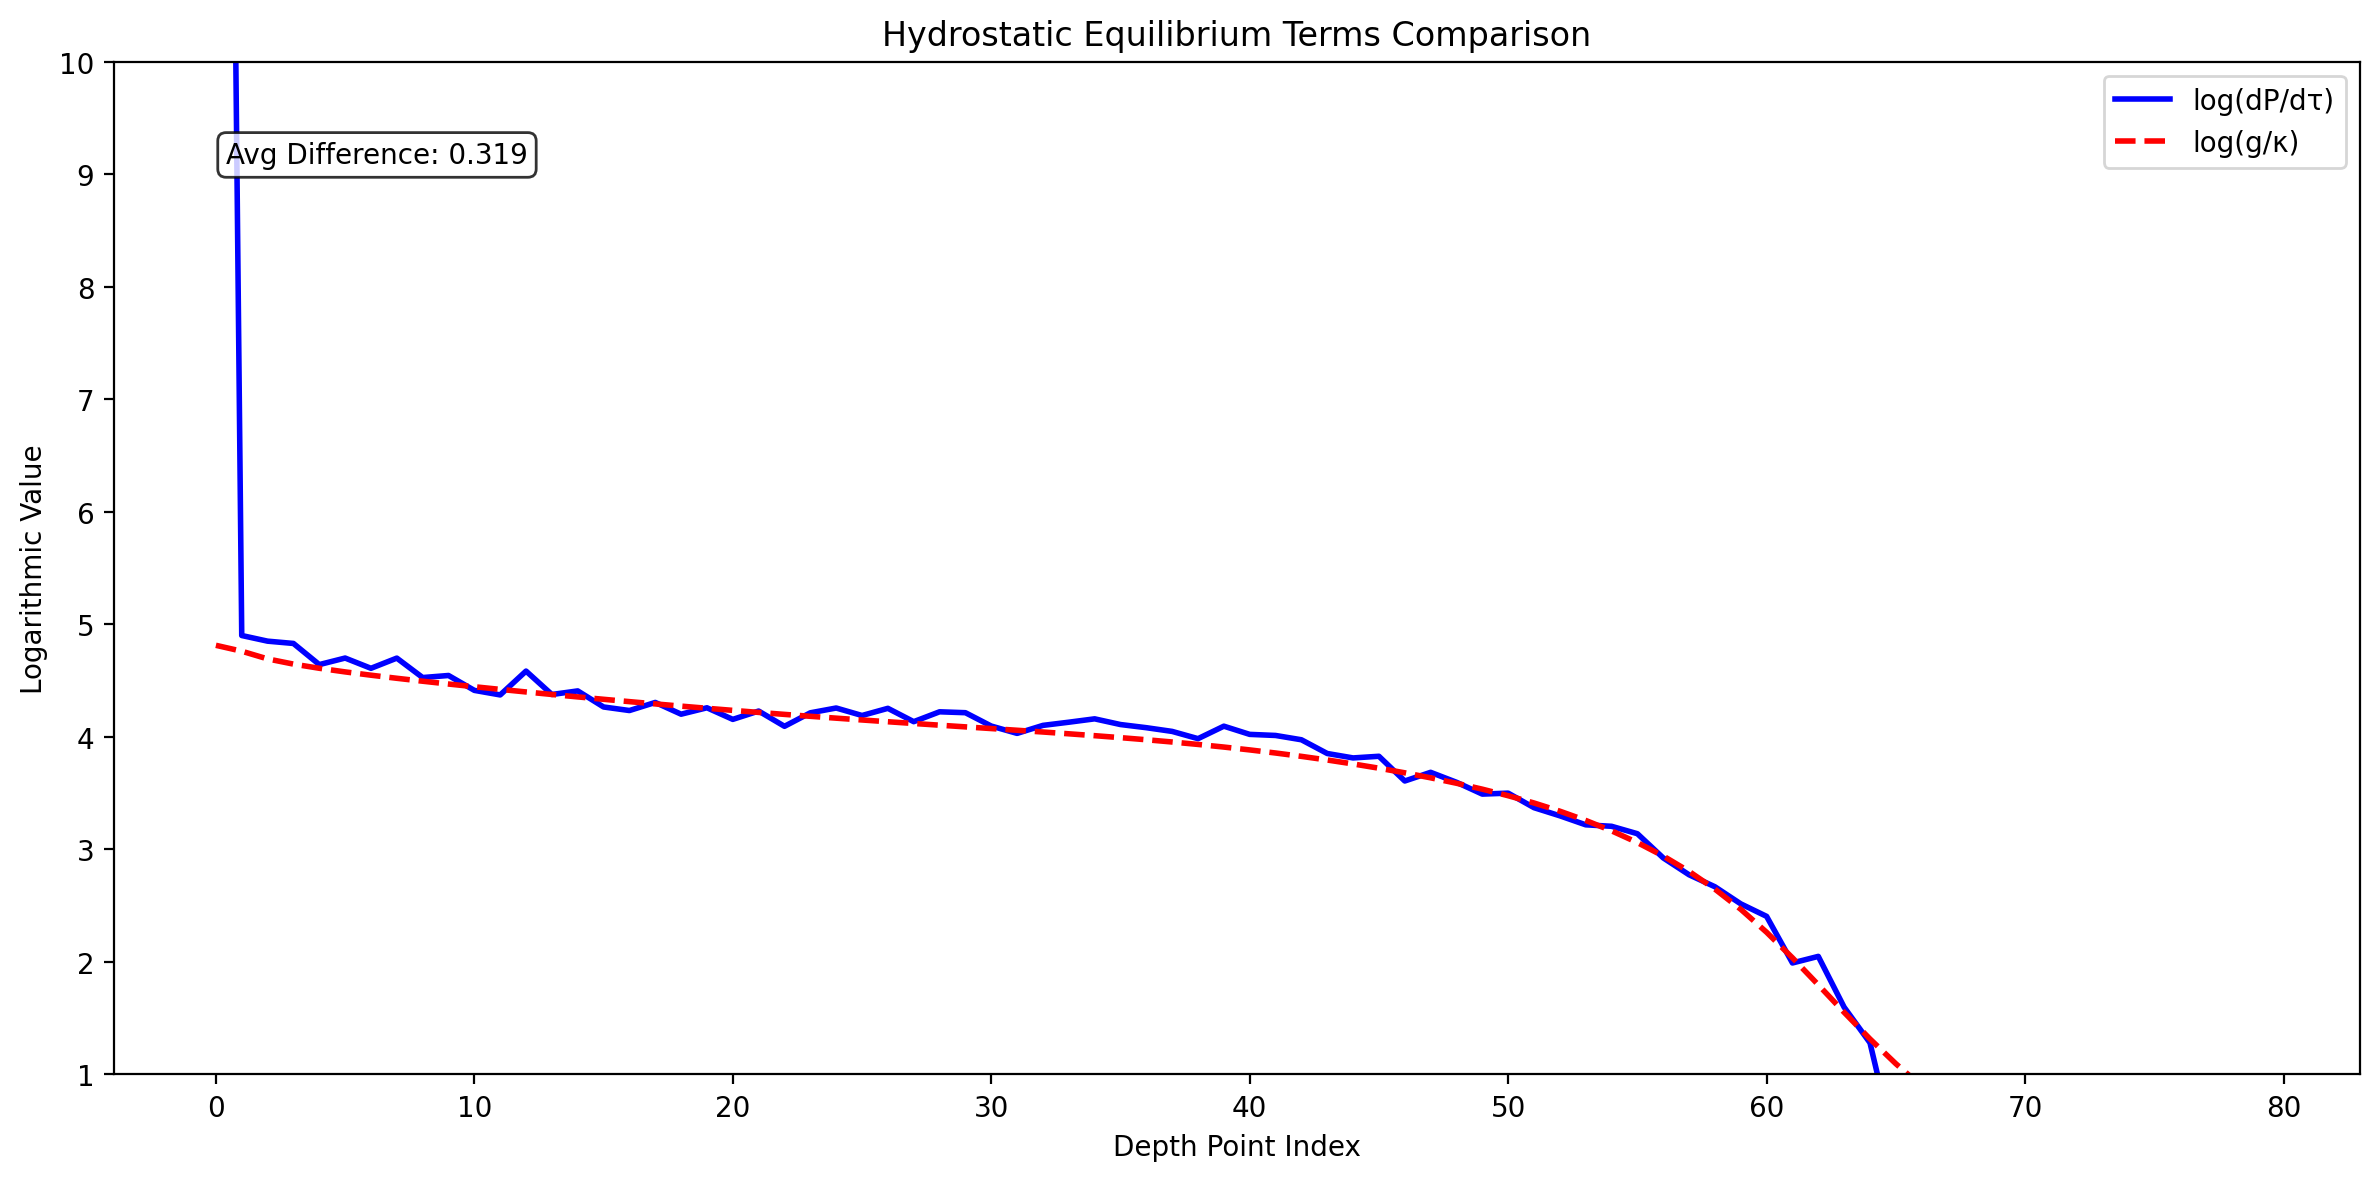

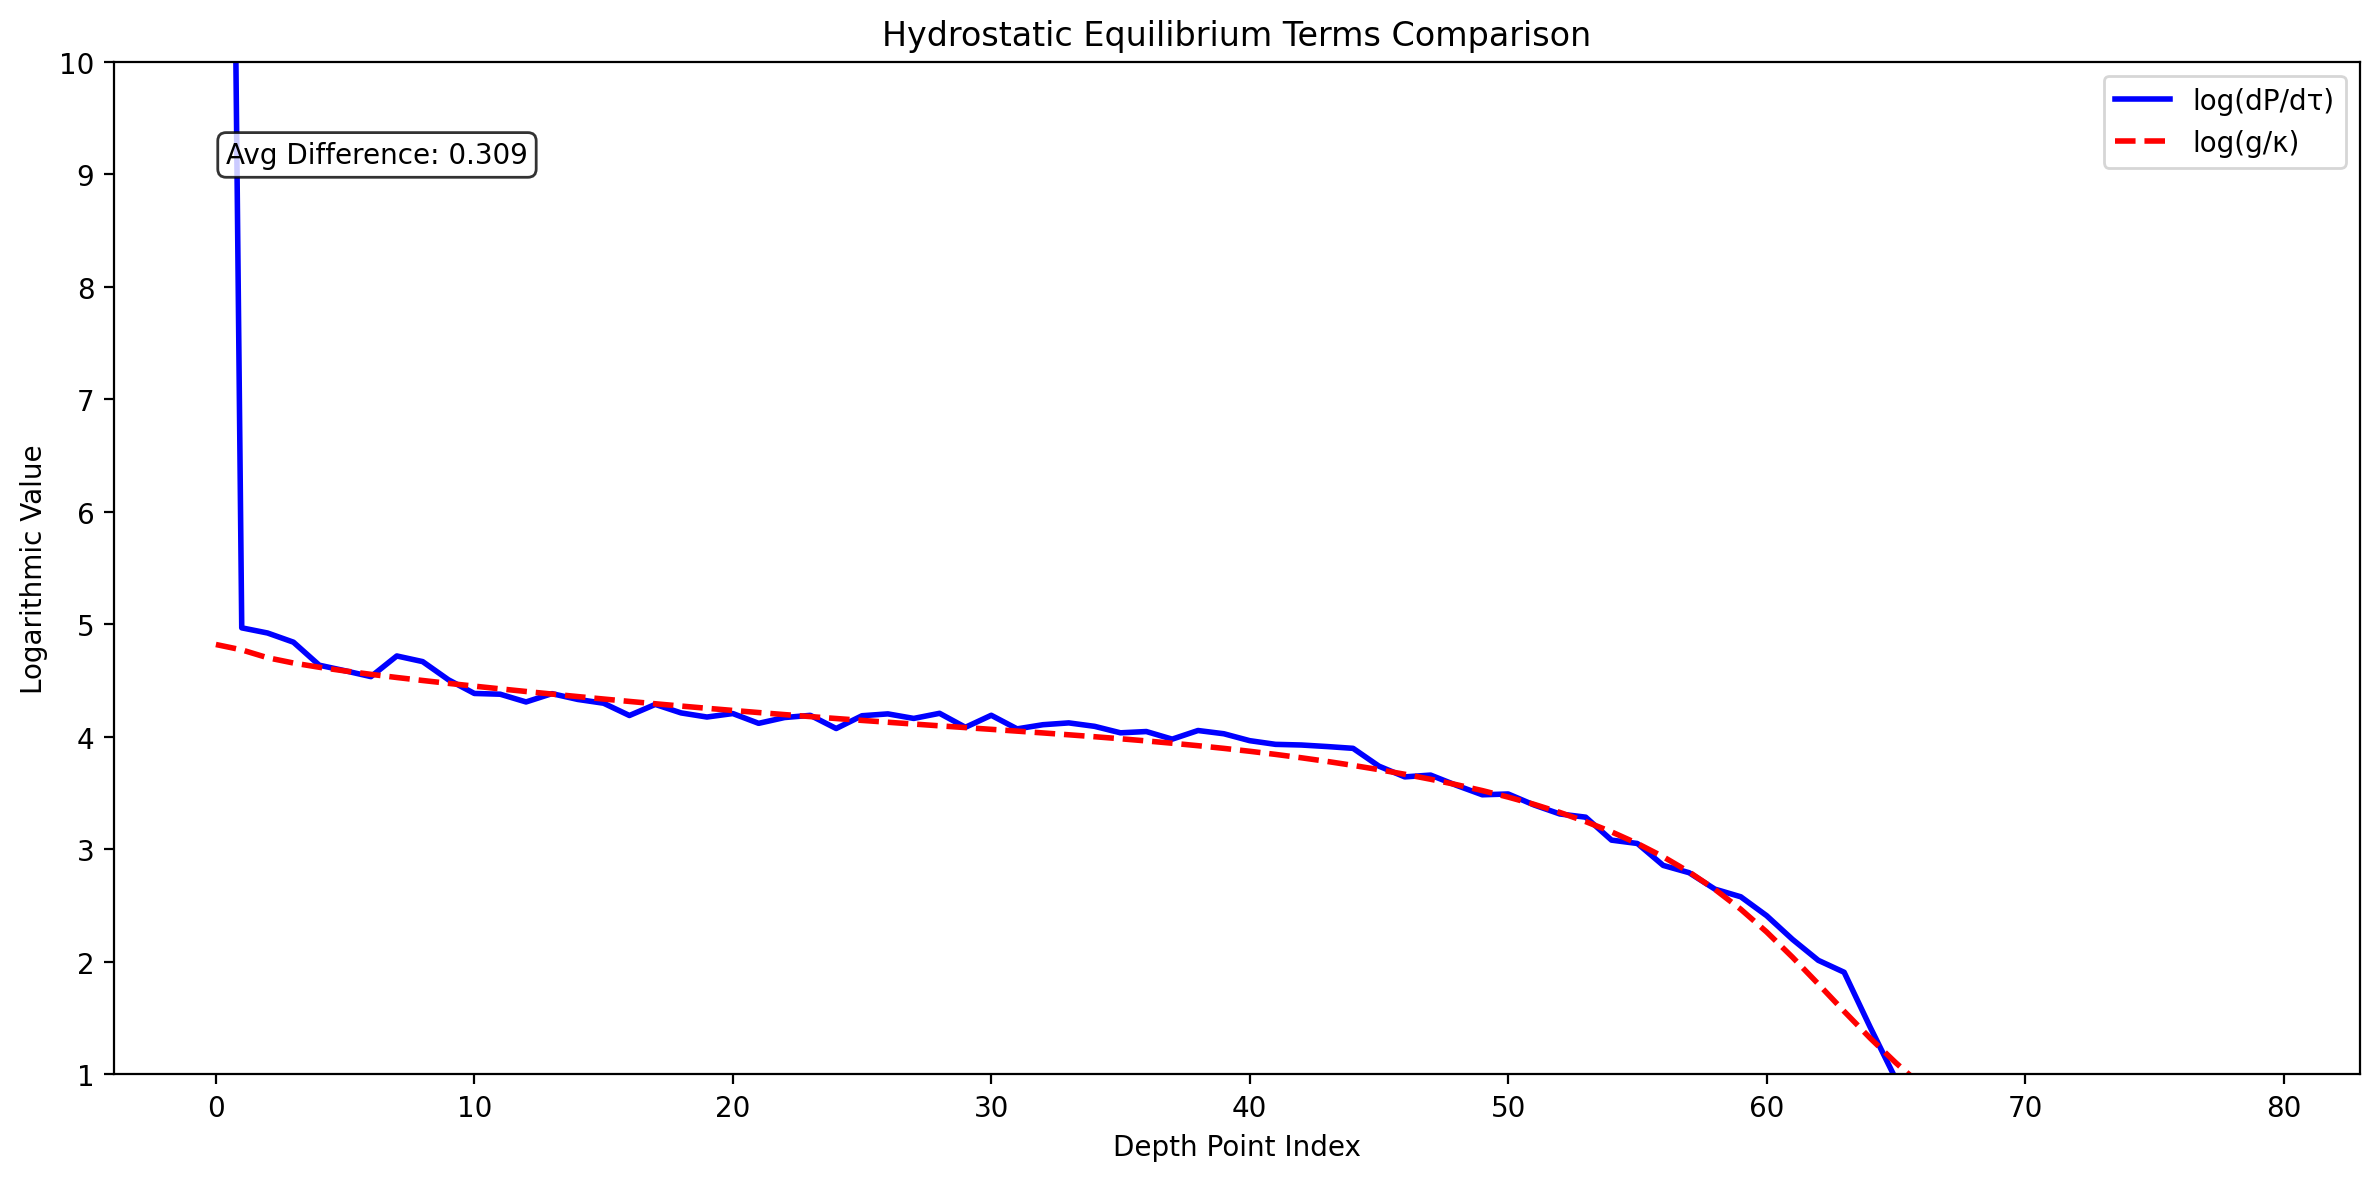

In [67]:
idx = 6
plot_hydro_terms(log_deriv_true, log_rhs_true, sample_idx=idx)  # 绘制第一个样本
plot_hydro_terms(log_deriv, log_rhs, sample_idx=idx)  # 绘制第一个样本
plot_hydro_terms(log_deriv_hydro, log_rhs_hydro, sample_idx=idx)  # 绘制第一个样本